In [34]:
import sys
sys.path.insert(0, "../")
import scanpy as sc
from model.embedding import embed
import numpy as np


# --- Configuration ---
# Choose the ground truth label column from embed_adata.obs
# 'cell1' (coarser) or 'cell2' (finer) are good candidates based on the data exploration cell
ground_truth_key = 'cell2'

In [35]:
model_dir = "../assets/"
adata_path = "../data/NB.bone.Met_preprocessed.h5ad" # INSERT the path to your anndata object here

# 1. Load the full AnnData object
print(f"Loading full AnnData object from: {adata_path}")
adata = sc.read_h5ad(adata_path)
print(f"Successfully loaded. Original shape: {adata.shape}")
print(adata)
# --- Subsampling Step ---
fraction_to_keep = 1.0
# For reproducibility of the random sampling
random_seed = 42
np.random.seed(random_seed)

""" n_obs_original = adata_full.n_obs
n_obs_to_keep = int(n_obs_original * fraction_to_keep)
print(f"Original number of observations: {n_obs_original}")
print(f"Target number of observations to keep ({(fraction_to_keep*100):.1f}%): {n_obs_to_keep}")
keep_indices = np.random.choice(n_obs_original, size=n_obs_to_keep, replace=False)
keep_indices.sort()

adata = adata_full[keep_indices, :].copy()
print(f"Created subset. New shape: {adata.shape}") """
""" # release memory used by the full object if it's very large (crashed windows pc...)
# import gc
# del adata_full
# gc.collect()
# print("Released memory from full AnnData object.")

# 6. Define keys for subsequent steps (using the subsetted 'adata')
batch_key = "sample"

# print(f"\nUsing subsetted AnnData object with keys: batch_key='{batch_key}', bio_key='{bio_key}'")
print(adata)

print("Unique values/types in 'cell1' column:")
# Access the 'cell1' column (which is a pandas Series) and get its unique values
print(adata.obs['cell1'].unique())
print("-" * 30) 

print("Unique values/types in 'cell2' column:")
# Access the 'cell2' column and get its unique values
print(adata.obs['cell2'].unique())
print("-" * 30) 

print("Unique values/types in 'sample' column:")
# Access the 'sample' column and get its unique values
print(adata.obs['sample'].unique())

# --- counts of each unique value ---

print("\nCounts for each unique value in 'cell1':")
print(adata.obs['cell1'].value_counts())
print("-" * 30)

print("Counts for each unique value in 'cell2':")
print(adata.obs['cell2'].value_counts())
print("-" * 30)

print("Counts for each unique value in 'sample':")
print(adata.obs['sample'].value_counts()) """

Loading full AnnData object from: ../data/NB.bone.Met_preprocessed.h5ad
Successfully loaded. Original shape: (36763, 25139)
AnnData object with n_obs × n_vars = 36763 × 25139
    obs: 'cell1', 'cell2', 'fraction', 'sample', 'cell_ID', 'n_genes', 'leiden'
    var: 'hgnc_symbol', 'ensembl_gene_id', 'gene_biotype', 'n_cells', 'mean', 'std'
    uns: 'leiden', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'RNA', 'log1p_norm'
    obsp: 'connectivities', 'distances'


' # release memory used by the full object if it\'s very large (crashed windows pc...)\n# import gc\n# del adata_full\n# gc.collect()\n# print("Released memory from full AnnData object.")\n\n# 6. Define keys for subsequent steps (using the subsetted \'adata\')\nbatch_key = "sample"\n\n# print(f"\nUsing subsetted AnnData object with keys: batch_key=\'{batch_key}\', bio_key=\'{bio_key}\'")\nprint(adata)\n\nprint("Unique values/types in \'cell1\' column:")\n# Access the \'cell1\' column (which is a pandas Series) and get its unique values\nprint(adata.obs[\'cell1\'].unique())\nprint("-" * 30) \n\nprint("Unique values/types in \'cell2\' column:")\n# Access the \'cell2\' column and get its unique values\nprint(adata.obs[\'cell2\'].unique())\nprint("-" * 30) \n\nprint("Unique values/types in \'sample\' column:")\n# Access the \'sample\' column and get its unique values\nprint(adata.obs[\'sample\'].unique())\n\n# --- counts of each unique value ---\n\nprint("\nCounts for each unique value in 

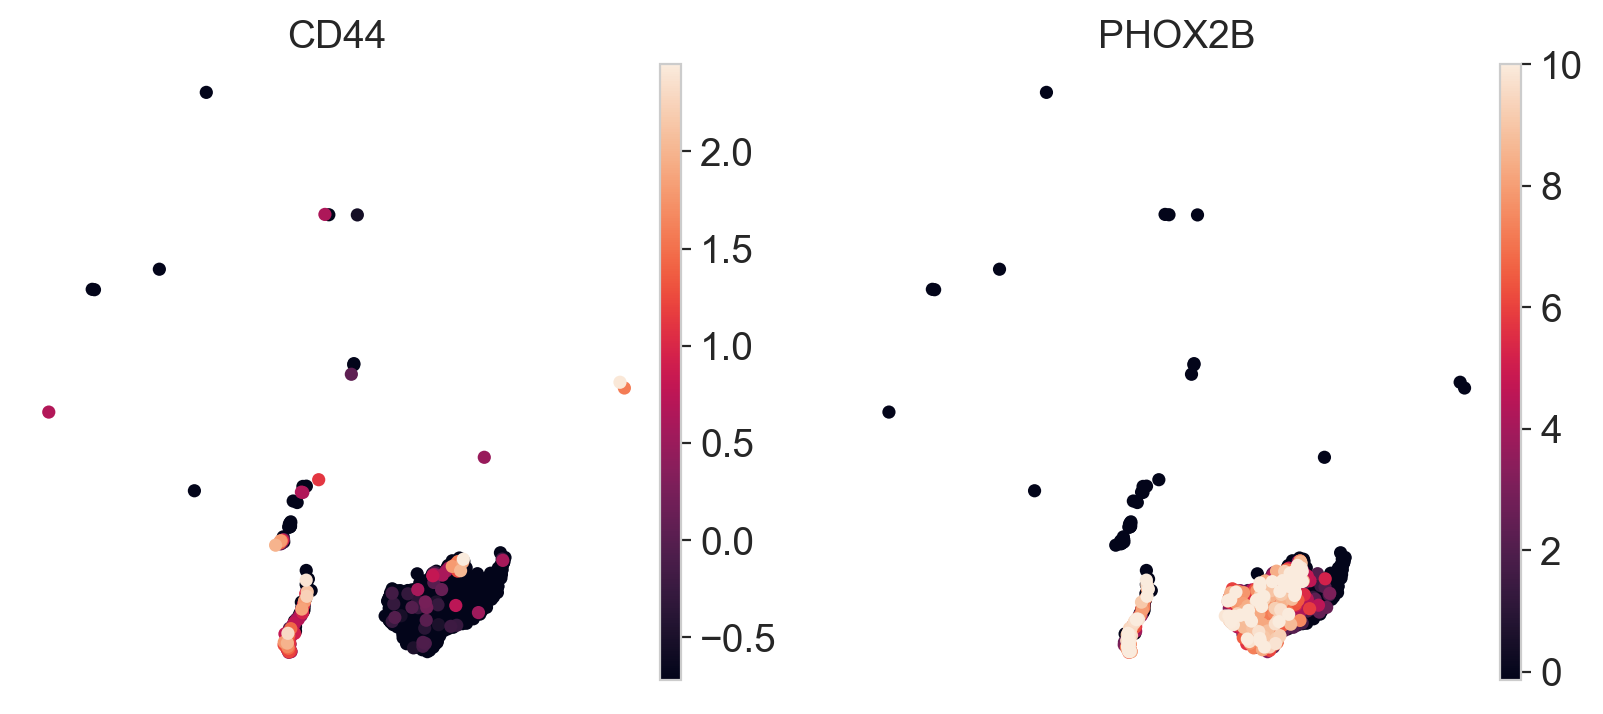

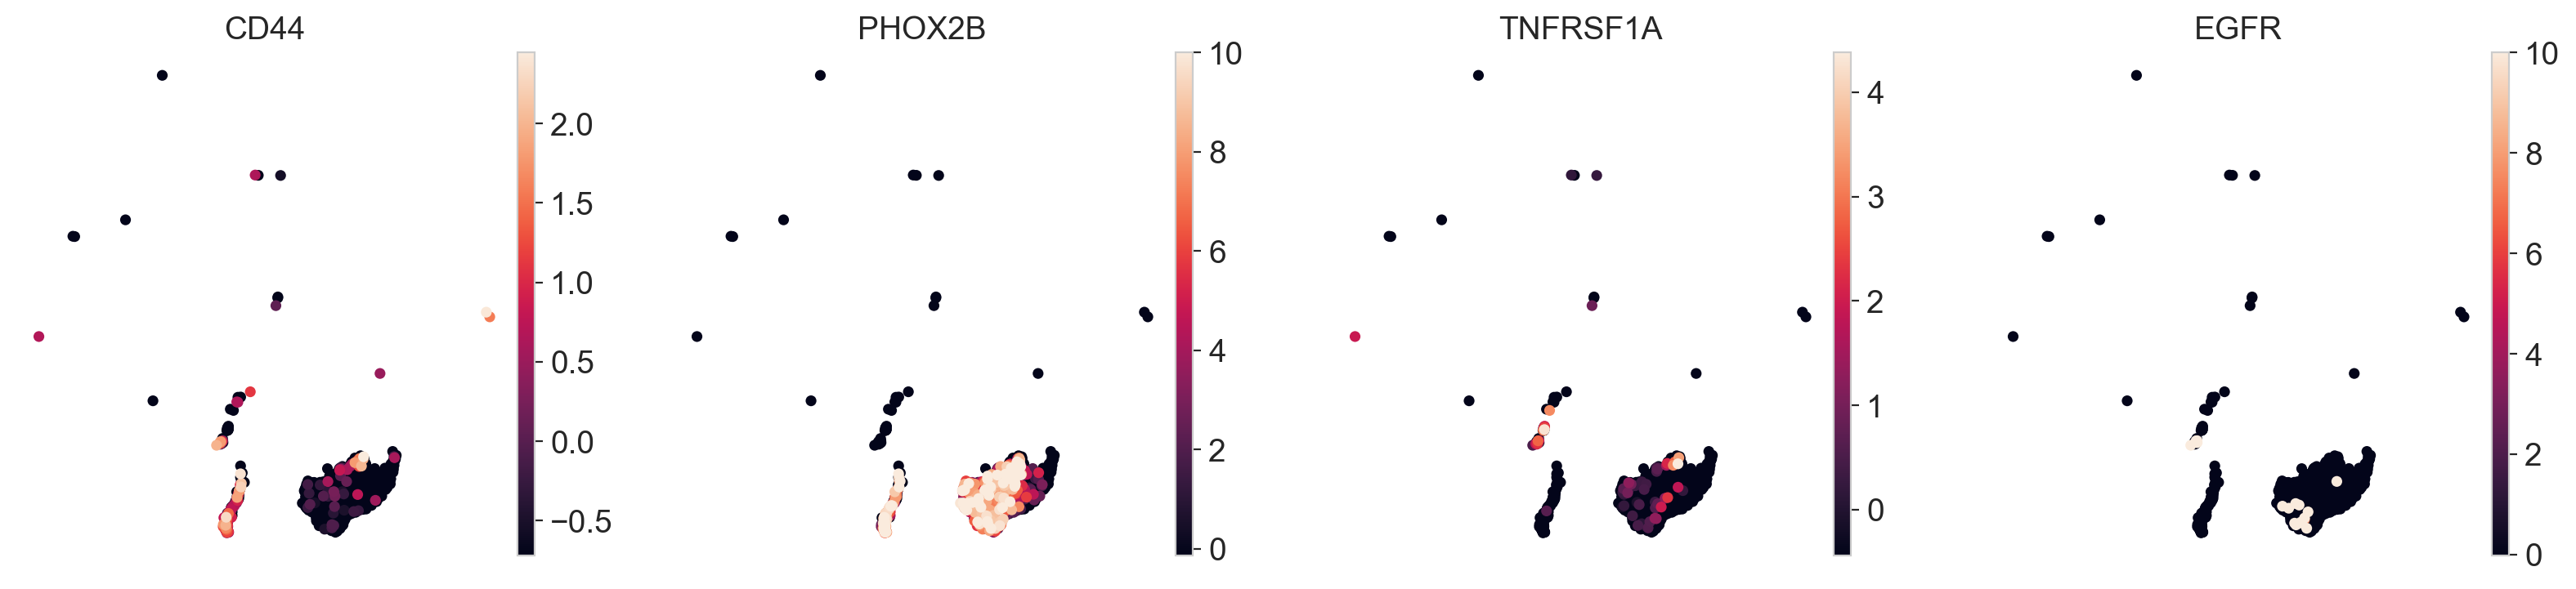

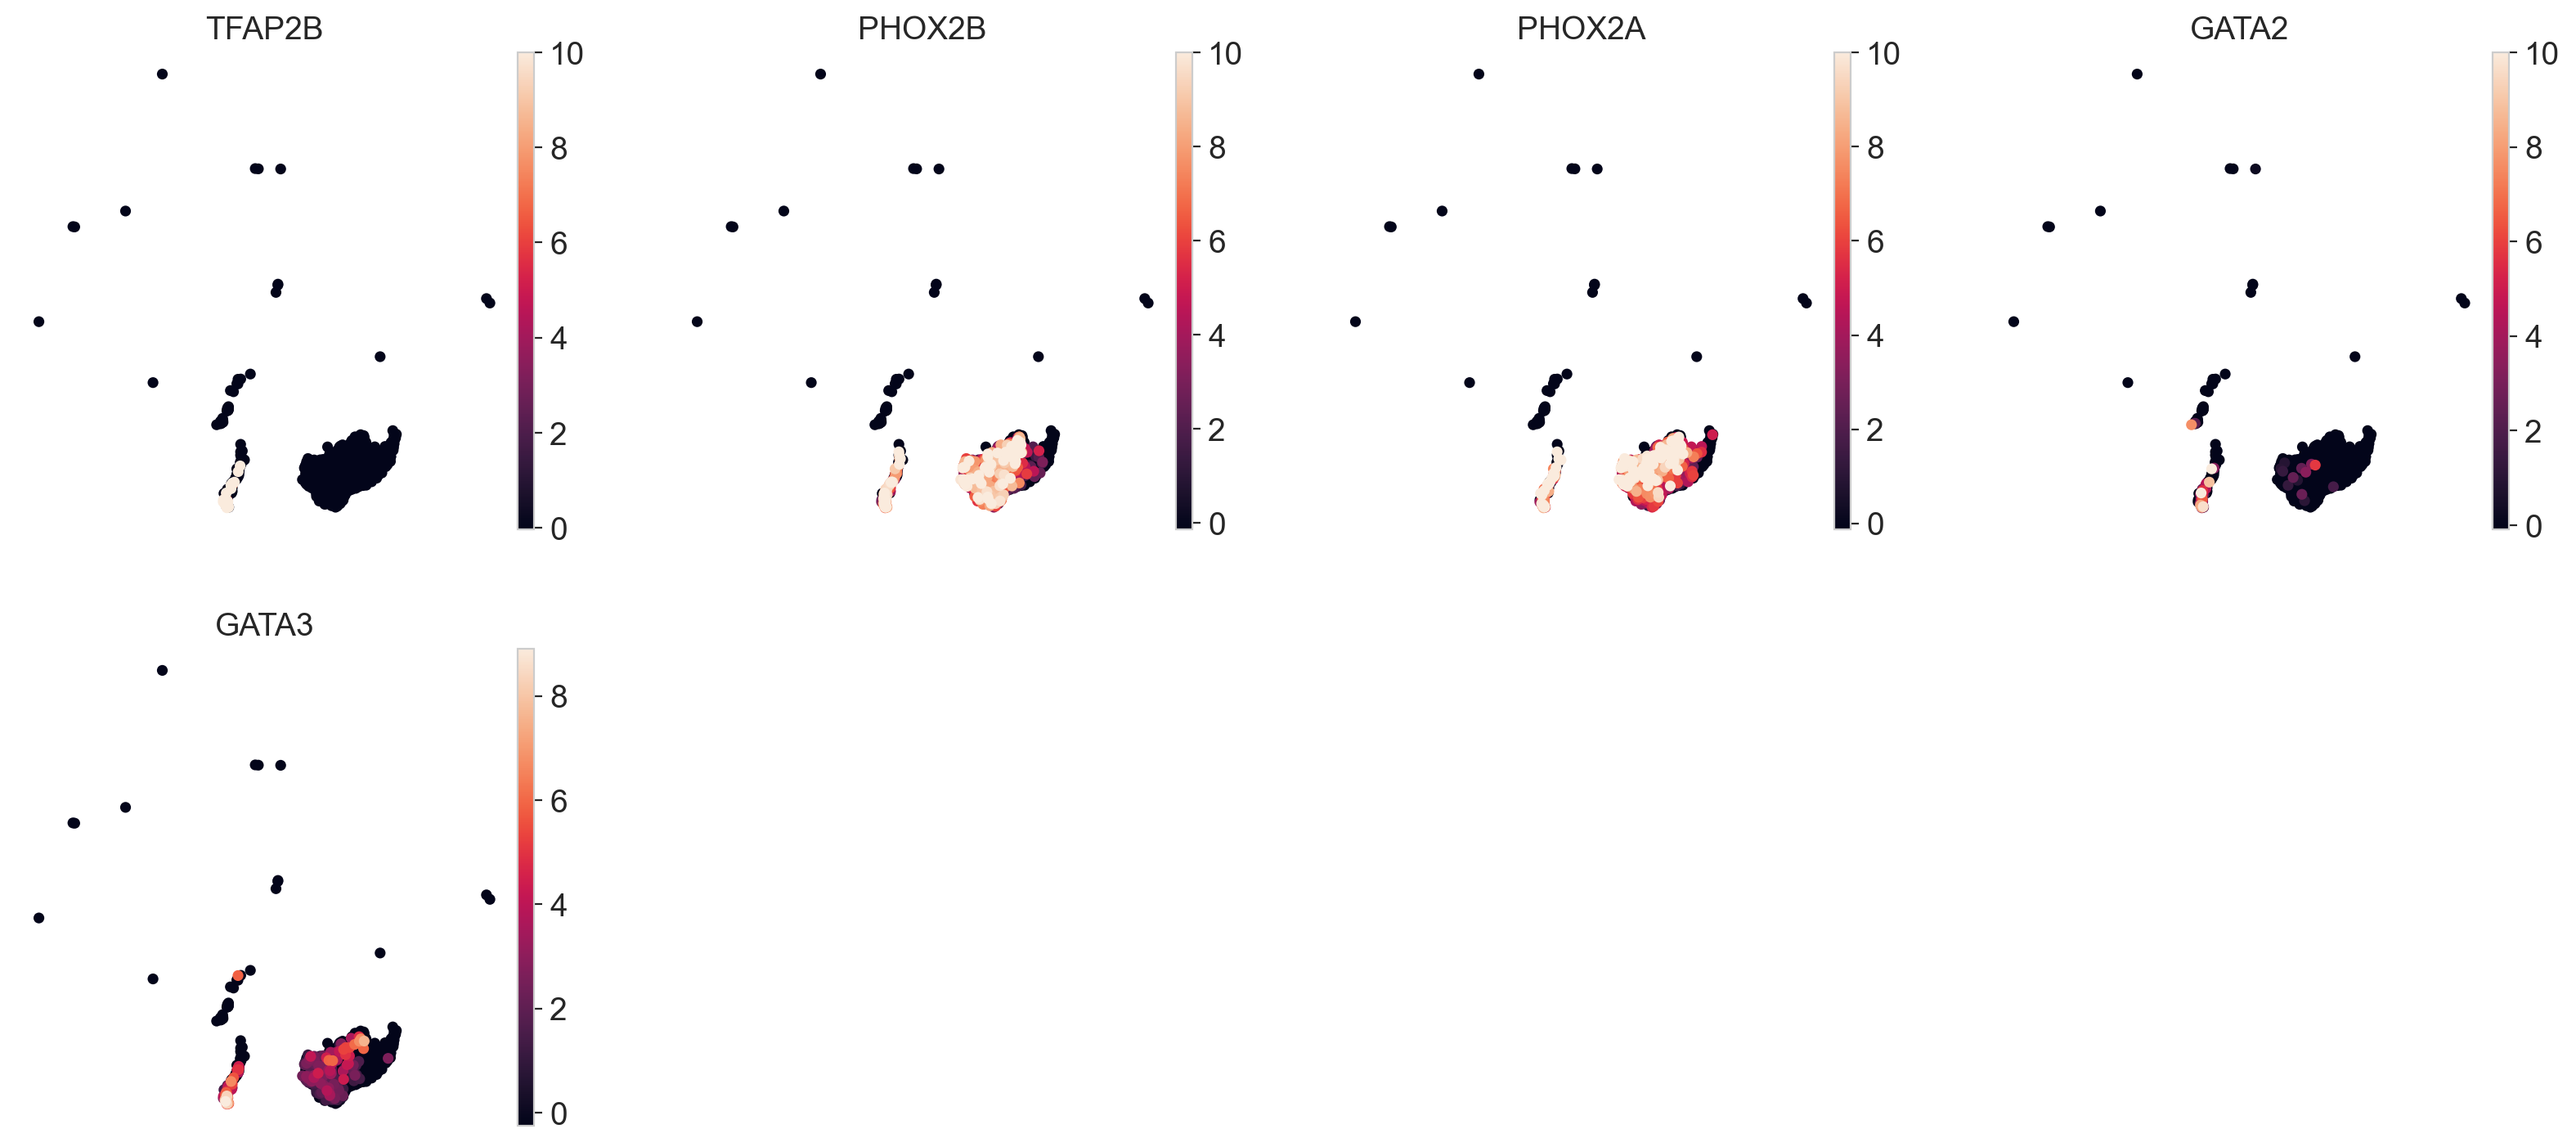

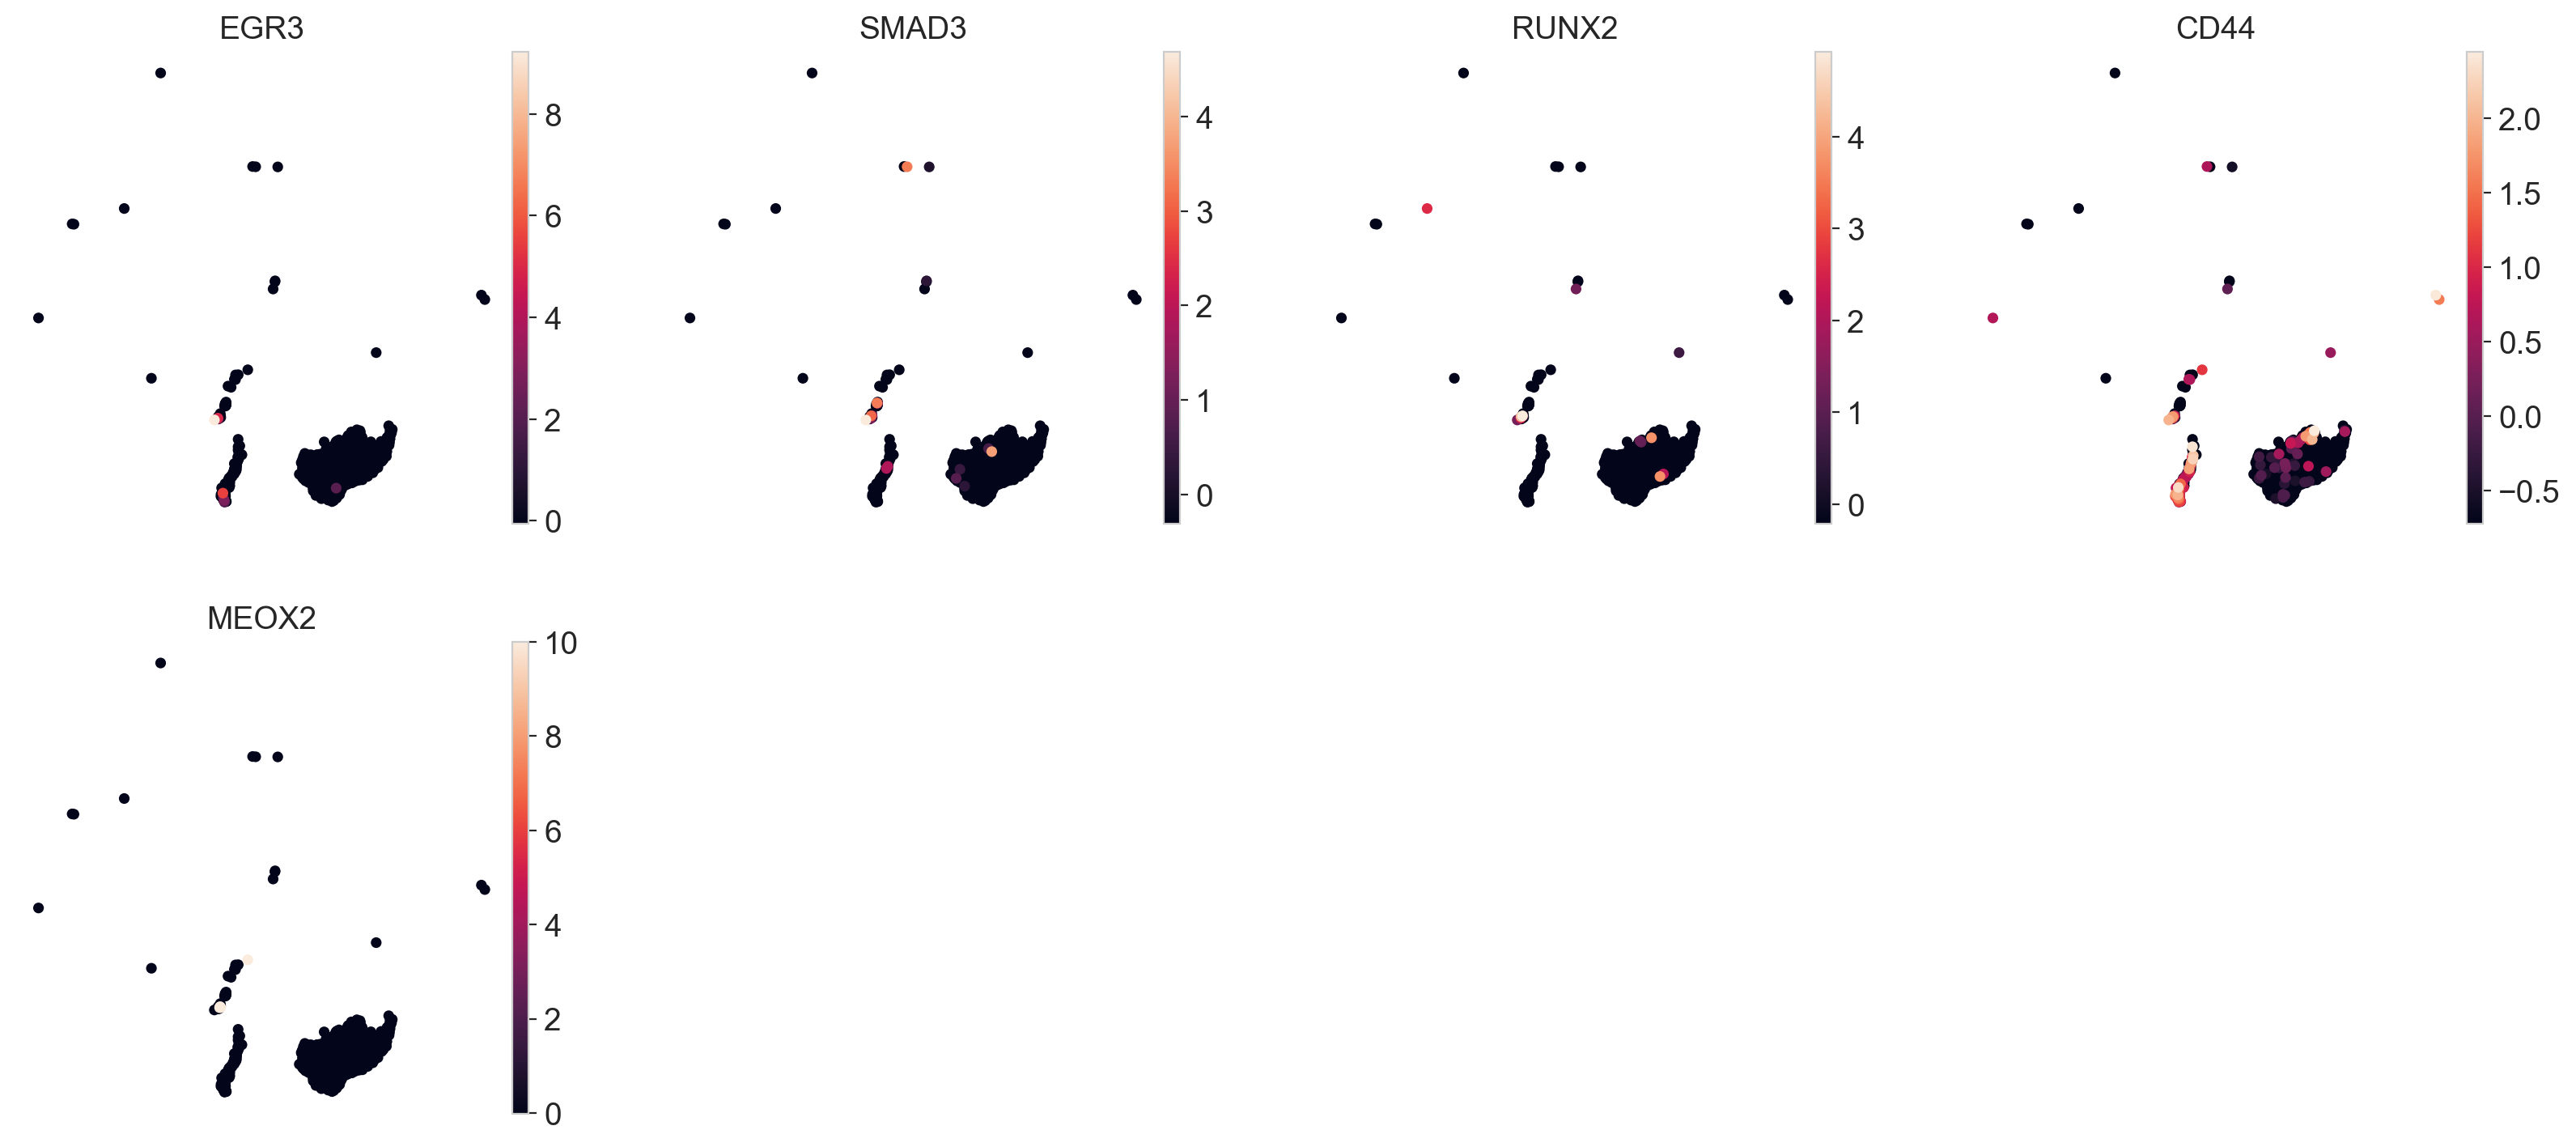

In [36]:
### Check the NOR and ADR signatures in the tumor cells ###

# 1) Subset the AnnData to only include Tumor cells
tumor_adata = adata[adata.obs["cell2"] == "Tumor"].copy()

# 2) Plot the expression of your genes of interest (e.g. "GeneA", "GeneB")
sc.pl.umap(tumor_adata, color=["CD44", "PHOX2B"])

# 3) Plot the expression of your genes of interest (e.g. "GeneA", "GeneB")

## PHOX2B ADR population
## CD44 MES
## TNFRSF1A AND EGFR Bridge to MES

sc.pl.umap(tumor_adata, color=["CD44", "PHOX2B", "TNFRSF1A", "EGFR"])

## NOR genes from https://www.nature.com/articles/s41467-023-38239-5/figures/4
sc.pl.umap(tumor_adata, color=["TFAP2B", "PHOX2B", "PHOX2A", "GATA2", "GATA3"])


## MES genes from https://www.nature.com/articles/s41467-023-38239-5/figures/4

sc.pl.umap(tumor_adata, color=["EGR3", "SMAD3", "RUNX2", "CD44", "MEOX2"])



In [37]:
print("Unique values/types in 'cell2' column:")
# Access the 'cell2' column and get its unique values
print(tumor_adata.obs['cell_ID'].unique())
print("-" * 30) 

Unique values/types in 'cell2' column:
['NBBM2_ACAACCACAACGAGGT-1' 'NBBM2_AGCTCAACAGATCATC-1'
 'NBBM2_AGCTCAAGTCTCAAGT-1' ... 'NB34_Bone_TTCTCTCAGTAGTCTC-1'
 'NB34_Bone_TTGAACGAGCCTATTG-1' 'NB34_Bone_TTTCAGTCACAATTCG-1']
------------------------------


In [38]:
import os
import scanpy as sc

# --- Configuration ---
output_filename = "NB.bone.Met_embedded.h5ad"
output_subdir = "data"
script_dir = os.path.dirname(os.path.abspath(__file__)) if '__file__' in locals() else os.getcwd()
output_embedded_path = os.path.join(script_dir, "..", output_subdir, output_filename)
batch_key = "sample"
batch_size = 64

# --- Check for Existing File or Perform Embedding ---
if os.path.exists(output_embedded_path):
    print(f"Loading existing embedded AnnData: {output_embedded_path}")
    embed_adata = sc.read_h5ad(output_embedded_path)
    print("Load complete.")
else:
    print(f"Embedded file not found: {output_embedded_path}")
    print("Performing embedding...")
    if 'adata' not in locals():
         raise NameError("Variable 'adata' is not defined.")

    embed_adata = embed(
        adata_or_file=adata,
        model_dir=model_dir,
        batch_key=batch_key,
        batch_size=batch_size,
    )
    print("Embedding complete.")

    # Save the newly embedded object
    print(f"\nSaving embedded AnnData object to: {output_embedded_path}")
    output_dir = os.path.dirname(output_embedded_path)
    if output_dir: # Ensure output_dir is not empty (e.g., saving in current dir)
        os.makedirs(output_dir, exist_ok=True)

    embed_adata.write(output_embedded_path, compression='gzip')
    print("Save complete.")

# --- Final Output ---
if embed_adata is not None:
    print("\n--- Loaded Embedded AnnData Object Info ---")
    print(embed_adata)
else:
    # This path is less likely without try-except but could occur if 'adata' was missing initially
    print("\nError: embed_adata object could not be loaded or created.")

cluster_only_tumor_cells = True # run eval only on latent embeddings of tumor cells
if cluster_only_tumor_cells:
    print("\n--- Clustering only on Tumor Cells ---")
    embed_adata = embed_adata[embed_adata.obs["cell2"] == "Tumor"].copy()
    print("--- Final Tumor Embedding Data Info ---")
    print(embed_adata)

Loading existing embedded AnnData: /Users/matinurdu/Desktop/ETH_Zürich/FS25/Foundation_models_NB/notebooks/../data/NB.bone.Met_embedded.h5ad
Load complete.

--- Loaded Embedded AnnData Object Info ---
AnnData object with n_obs × n_vars = 36763 × 1199
    obs: 'cell1', 'cell2', 'fraction', 'sample', 'cell_ID', 'n_genes', 'leiden'
    var: 'hgnc_symbol', 'ensembl_gene_id', 'gene_biotype', 'n_cells', 'mean', 'std', 'genes', 'id_in_vocab', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg', 'leiden', 'neighbors', 'pca', 'umap'
    obsm: 'CancerGPT', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'RNA', 'log1p_norm'
    obsp: 'connectivities', 'distances'

--- Clustering only on Tumor Cells ---
--- Final Tumor Embedding Data Info ---
AnnData object with n_obs × n_vars = 1327 × 1199
    obs: 'cell1', 'cell2', 'fraction', 'sample', 'cell_ID', 'n_genes', 'leiden'
    var: 'hgnc_symbol', 'ensembl_gene_id', 'ge

In [39]:
sc.pp.neighbors(embed_adata, use_rep="CancerGPT")
sc.tl.umap(embed_adata)
sc.tl.leiden(adata, flavor='igraph', n_iterations=2)
for feature in ["cell1", "cell2", "fraction", "sample"]:
    sc.pl.umap(adata, color=feature, show=False, save=f"_harmony_{feature}.png")
    sc.pl.umap(embed_adata, color=feature, show=False, save=f"_embed_{feature}.png")

Fitting GMM with 13 components...
Calculating entropy...
Added 'GMM_probabilities' to embed_adata.obsm
Added 'GMM_entropy' to embed_adata.obs
Added 'GMM_cluster' (dominant cluster) to embed_adata.obs

Done with GMM and entropy calculation.

--- Starting Visualization (using embedding: 'X_umap') ---
Plotting dominant GMM clusters on X_umap...


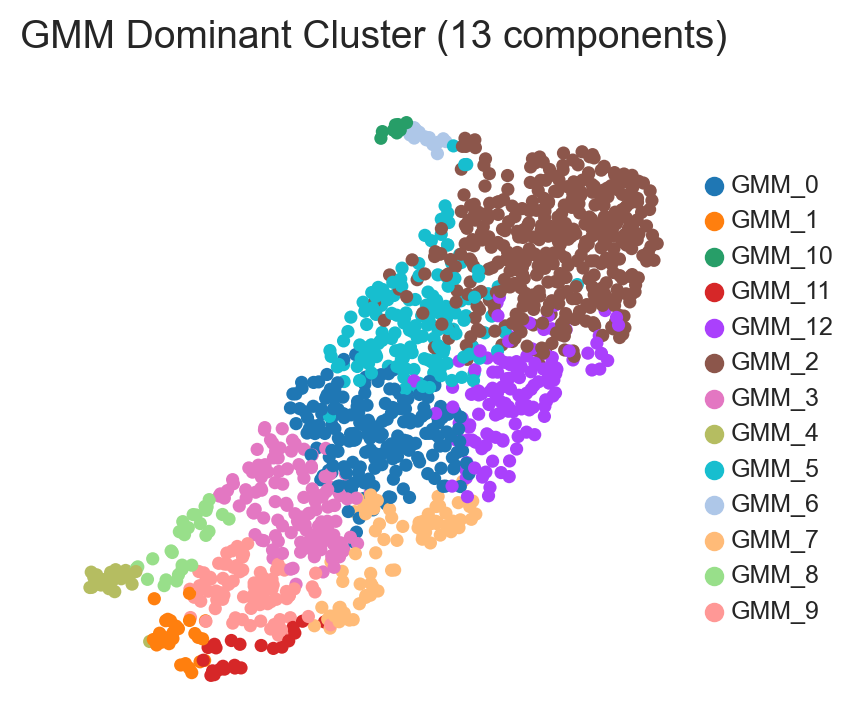

Plotting GMM entropy on X_umap...


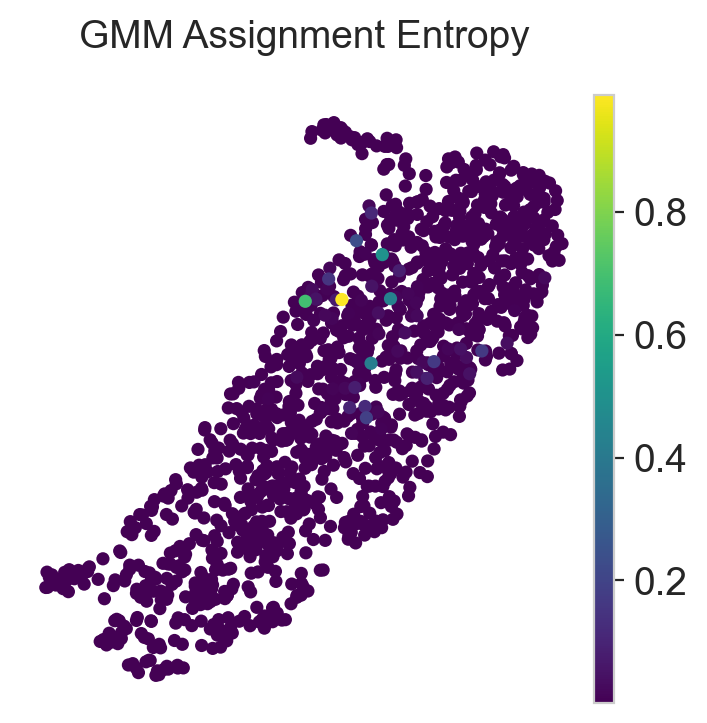

Plotting clusters and entropy side-by-side on X_umap...


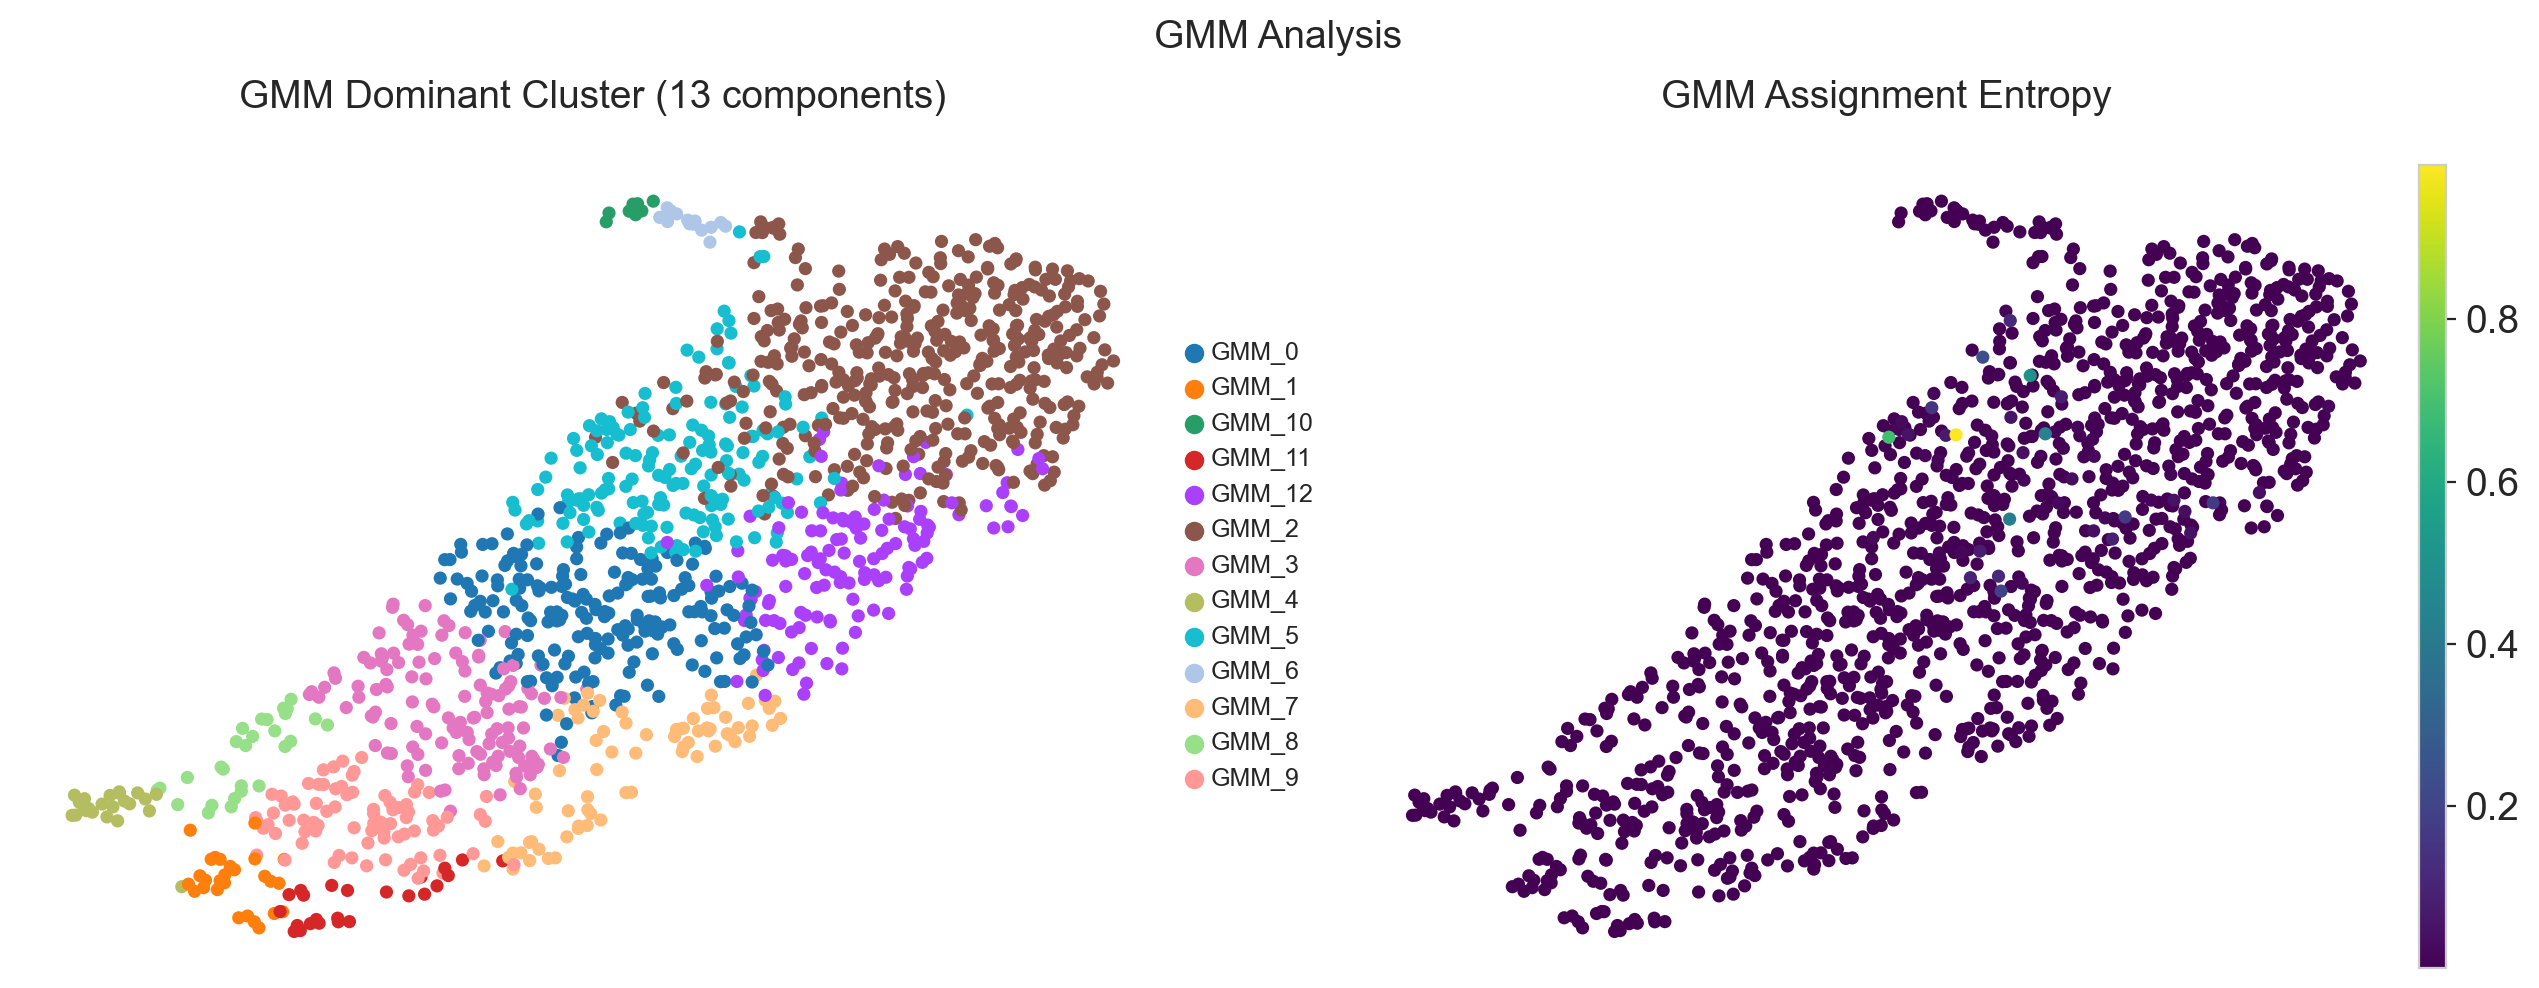

<Axes: title={'center': 'cell2'}, xlabel='X_umap1', ylabel='X_umap2'>

In [40]:
# --- GMM Soft Clustering and Entropy Calculation ---
from sklearn.mixture import GaussianMixture
from scipy.stats import entropy
import numpy as np
import matplotlib.pyplot as plt  # <<< ENSURE THIS IS IMPORTED
import seaborn as sns 

n_clusters = 13  # Specify the desired number of clusters (components) - adjust as needed


embeddings = embed_adata.obsm['CancerGPT']
print(f"Fitting GMM with {n_clusters} components...")
gmm = GaussianMixture(n_components=n_clusters,
                      random_state=random_seed,
                      covariance_type='full') # 'full' is default, other options: 'tied', 'diag', 'spherical'
gmm.fit(embeddings)


gmm_probabilities = gmm.predict_proba(embeddings)
print("Calculating entropy...")
# Entropy H(p) = - sum(p_i * log2(p_i))
# Add a small epsilon to avoid log(0)
epsilon = 1e-9
cell_entropy = entropy(gmm_probabilities.T + epsilon, base=2)

# 6. Store results in AnnData object
embed_adata.obsm['GMM_probabilities'] = gmm_probabilities
print("Added 'GMM_probabilities' to embed_adata.obsm")
embed_adata.obs['GMM_entropy'] = cell_entropy
print("Added 'GMM_entropy' to embed_adata.obs")

# --- Add Dominant Cluster Assignment ---
# Find the cluster index with the highest probability for each cell
dominant_cluster = np.argmax(gmm_probabilities, axis=1)
# Store as categorical strings for better plotting with scanpy
embed_adata.obs['GMM_cluster'] = [f'GMM_{c}' for c in dominant_cluster]
embed_adata.obs['GMM_cluster'] = embed_adata.obs['GMM_cluster'].astype('category')
print("Added 'GMM_cluster' (dominant cluster) to embed_adata.obs")

print("\nDone with GMM and entropy calculation.")

embedding_key = 'X_umap'
# --- Visualization ---
print(f"\n--- Starting Visualization (using embedding: '{embedding_key}') ---")


sc.settings.set_figure_params(dpi=100, facecolor='white', frameon=False)
sns.set_style("whitegrid") # Or "white", "ticks", etc.

# --- Titles ---
title_cluster = f'GMM Dominant Cluster ({n_clusters} components)'
title_entropy = 'GMM Assignment Entropy'
title_y_position = 1.05 # Adjust this value to move title further up (e.g., 1.05) or down (e.g., 1.01)

# 1. Visualize Dominant GMM Clusters
print(f"Plotting dominant GMM clusters on {embedding_key}...")
fig1, ax1 = plt.subplots()
sc.pl.embedding(embed_adata,
                basis=embedding_key,
                color='GMM_cluster',
                legend_loc='right margin',
                legend_fontsize=9,
                ax=ax1,
                show=False)

# Set title manually using matplotlib with adjusted vertical position
ax1.set_title(title_cluster, y=title_y_position)
# plt.savefig(f'gmm_clusters_{embedding_key}.png', dpi=output_fig_dpi, bbox_inches='tight')
plt.show()

# 2. Visualize GMM Assignment Entropy
print(f"Plotting GMM entropy on {embedding_key}...")
fig2, ax2 = plt.subplots()
sc.pl.embedding(embed_adata,
                basis=embedding_key,
                color='GMM_entropy',

                cmap='viridis',
                colorbar_loc='right',
                ax=ax2,
                show=False)
# Set title manually using matplotlib with adjusted vertical position
ax2.set_title(title_entropy, y=title_y_position)
# plt.savefig(f'gmm_entropy_{embedding_key}.png', dpi=output_fig_dpi, bbox_inches='tight')
plt.show()

# 3. Visualize Both Side-by-Side 
print(f"Plotting clusters and entropy side-by-side on {embedding_key}...")
fig3, axes = plt.subplots(1, 2, figsize=(13, 5))

# Plot Clusters on the left
sc.pl.embedding(embed_adata,
                basis=embedding_key,
                color='GMM_cluster',
                title=None, # Remove title from scanpy call
                legend_loc='right margin',
                legend_fontsize=9,
                ax=axes[0],
                show=False)
axes[0].set_title(title_cluster, y=title_y_position) # Set title manually
axes[0].set_xlabel(f"{embedding_key.split('_')[-1].upper()} 1")
axes[0].set_ylabel(f"{embedding_key.split('_')[-1].upper()} 2")

# Plot Entropy on the right
sc.pl.embedding(embed_adata,
                basis=embedding_key,
                color='GMM_entropy',
                title=None, # Remove title from scanpy call
                cmap='viridis',
                colorbar_loc='right',
                ax=axes[1],
                show=False)

axes[1].set_title(title_entropy, y=title_y_position) # Set title manually
axes[1].set_xlabel(f"{embedding_key.split('_')[-1].upper()} 1")
axes[1].set_ylabel(f"{embedding_key.split('_')[-1].upper()} 2")


# Use tight_layout *after* setting titles
plt.tight_layout(rect=[0, 0, 1, 0.97]) # Add rect to potentially leave space for suptitle if needed, adjust top value (0.97) if titles still overlap
fig3.suptitle("GMM Analysis", fontsize=14, y=0.99) # Example suptitle

# plt.savefig(f'gmm_clusters_entropy_{embedding_key}_combined.png', dpi=output_fig_dpi, bbox_inches='tight')
plt.show()
sc.pl.embedding(embed_adata,
                basis=embedding_key,
                color=ground_truth_key,
                legend_loc='right margin',
                legend_fontsize=9,
                ax=ax1,
                show=False)


In [41]:
# --- 3a: K-Means Clustering ---
# Decide on the number of clusters for k-means.
import pandas as pd
from sklearn.cluster import KMeans

n_clusters_kmeans = n_clusters 
print(f"Running K-Means with {n_clusters_kmeans} clusters on embeddings...")
kmeans = KMeans(n_clusters=n_clusters_kmeans, random_state=random_seed, n_init=10)
kmeans_labels = kmeans.fit_predict(embeddings)
embed_adata.obs['kmeans'] = pd.Categorical([f'KMeans_{c}' for c in kmeans_labels])
print(f"Stored K-Means results in embed_adata.obs['kmeans']")


# --- 3b: Louvain Clustering ---
# Louvain uses the neighbors graph computed earlier
# Resolution parameter influences the number of clusters found. Tune as needed.
print("Running Louvain clustering...")
sc.tl.louvain(embed_adata, random_state=random_seed, key_added='louvain') # Default resolution=1.0
print(f"Stored Louvain results in embed_adata.obs['louvain']")
# Visualize number of clusters found
print(f"Found {len(embed_adata.obs['louvain'].cat.categories)} Louvain clusters.")

# --- 3c: Leiden Clustering ---
# Leiden also uses the neighbors graph and is generally preferred over Louvain
print("Running Leiden clustering...")
sc.tl.leiden(embed_adata, random_state=random_seed, key_added='leiden') # Default resolution=1.0
print(f"Stored Leiden results in embed_adata.obs['leiden']")
# Visualize number of clusters found
print(f"Found {len(embed_adata.obs['leiden'].cat.categories)} Leiden clusters.")


Running K-Means with 13 clusters on embeddings...
Stored K-Means results in embed_adata.obs['kmeans']
Running Louvain clustering...
Stored Louvain results in embed_adata.obs['louvain']
Found 8 Louvain clusters.
Running Leiden clustering...
Stored Leiden results in embed_adata.obs['leiden']
Found 11 Leiden clusters.



--- Starting Evaluation Against Known Cell Labels ---


--- 1. Clustering Evaluation Metrics (vs 'cell2') ---

Evaluating: GMM_cluster
  Adjusted Rand Index (ARI): 0.0000
  Normalized Mutual Info (NMI): 0.0000
  Homogeneity: 1.0000
  Completeness: 0.0000
  V-Measure: 0.0000

Evaluating: kmeans
  Adjusted Rand Index (ARI): 0.0000
  Normalized Mutual Info (NMI): 0.0000
  Homogeneity: 1.0000
  Completeness: 0.0000
  V-Measure: 0.0000

Evaluating: louvain
  Adjusted Rand Index (ARI): 0.0000
  Normalized Mutual Info (NMI): 0.0000
  Homogeneity: 1.0000
  Completeness: 0.0000
  V-Measure: 0.0000

Evaluating: leiden
  Adjusted Rand Index (ARI): 0.0000
  Normalized Mutual Info (NMI): 0.0000
  Homogeneity: 1.0000
  Completeness: 0.0000
  V-Measure: 0.0000

--- Metrics Summary ---
             ARI  NMI  Homogeneity  Completeness  V-Measure
GMM_cluster  0.0  0.0          1.0           0.0        0.0
kmeans       0.0  0.0          1.0           0.0        0.0
louvain      0.0  0.0          1.0    

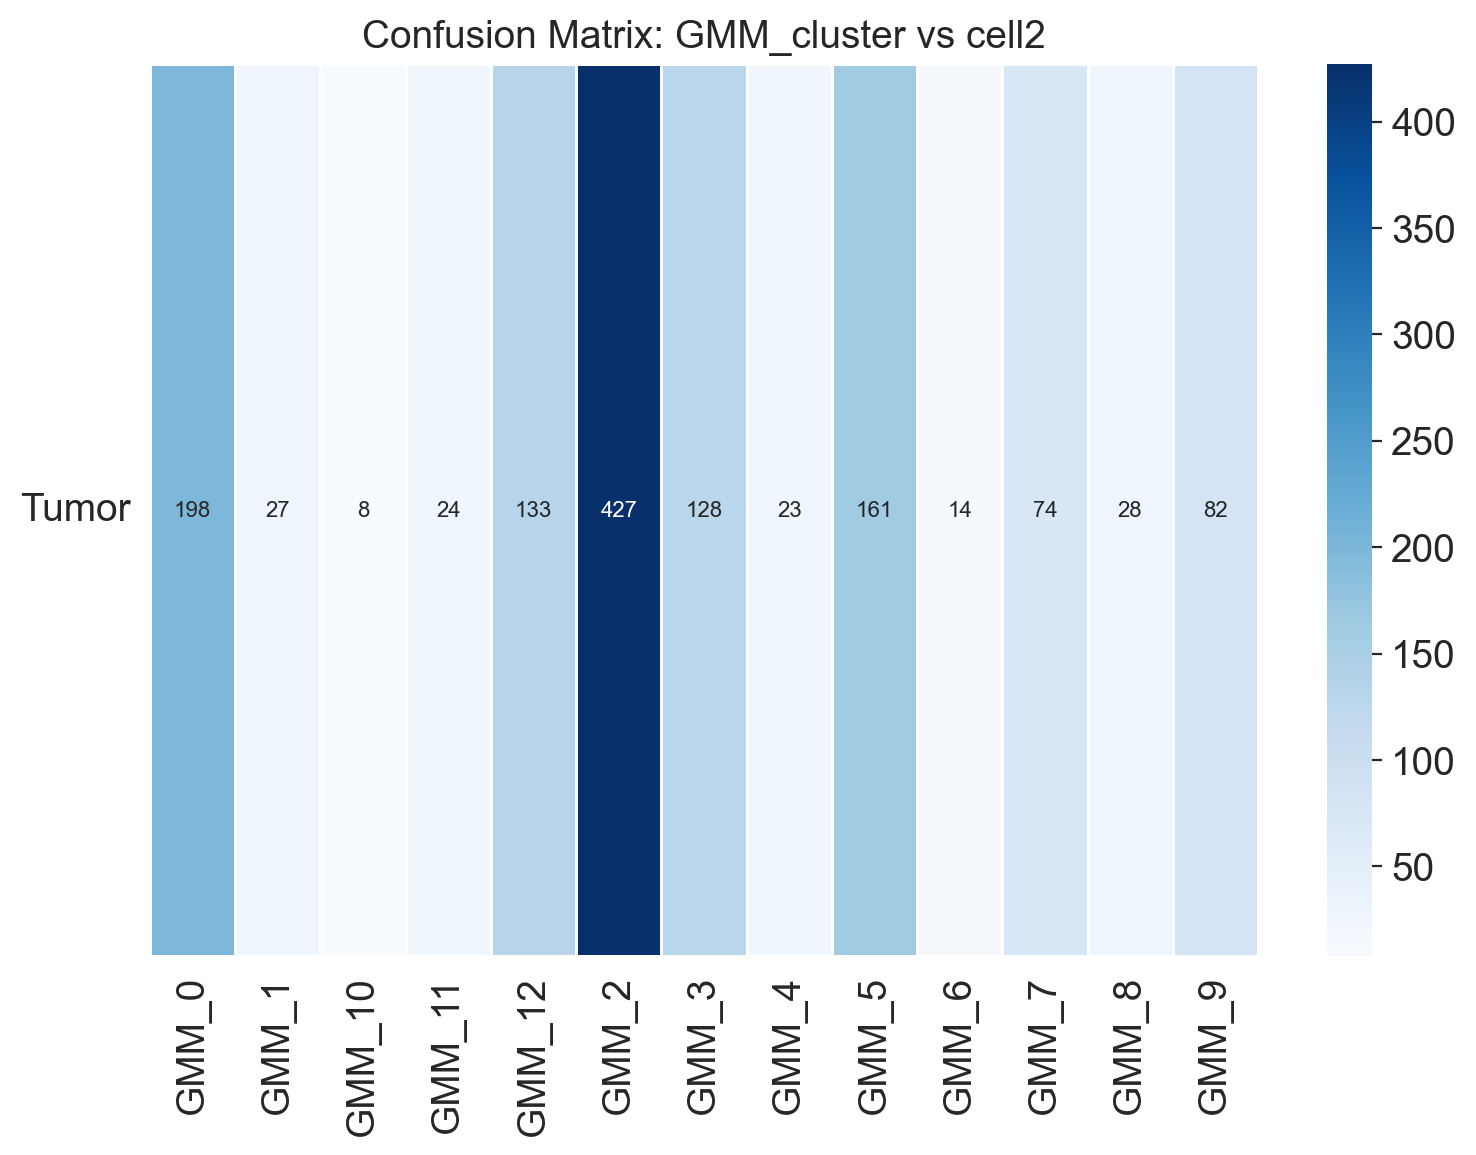

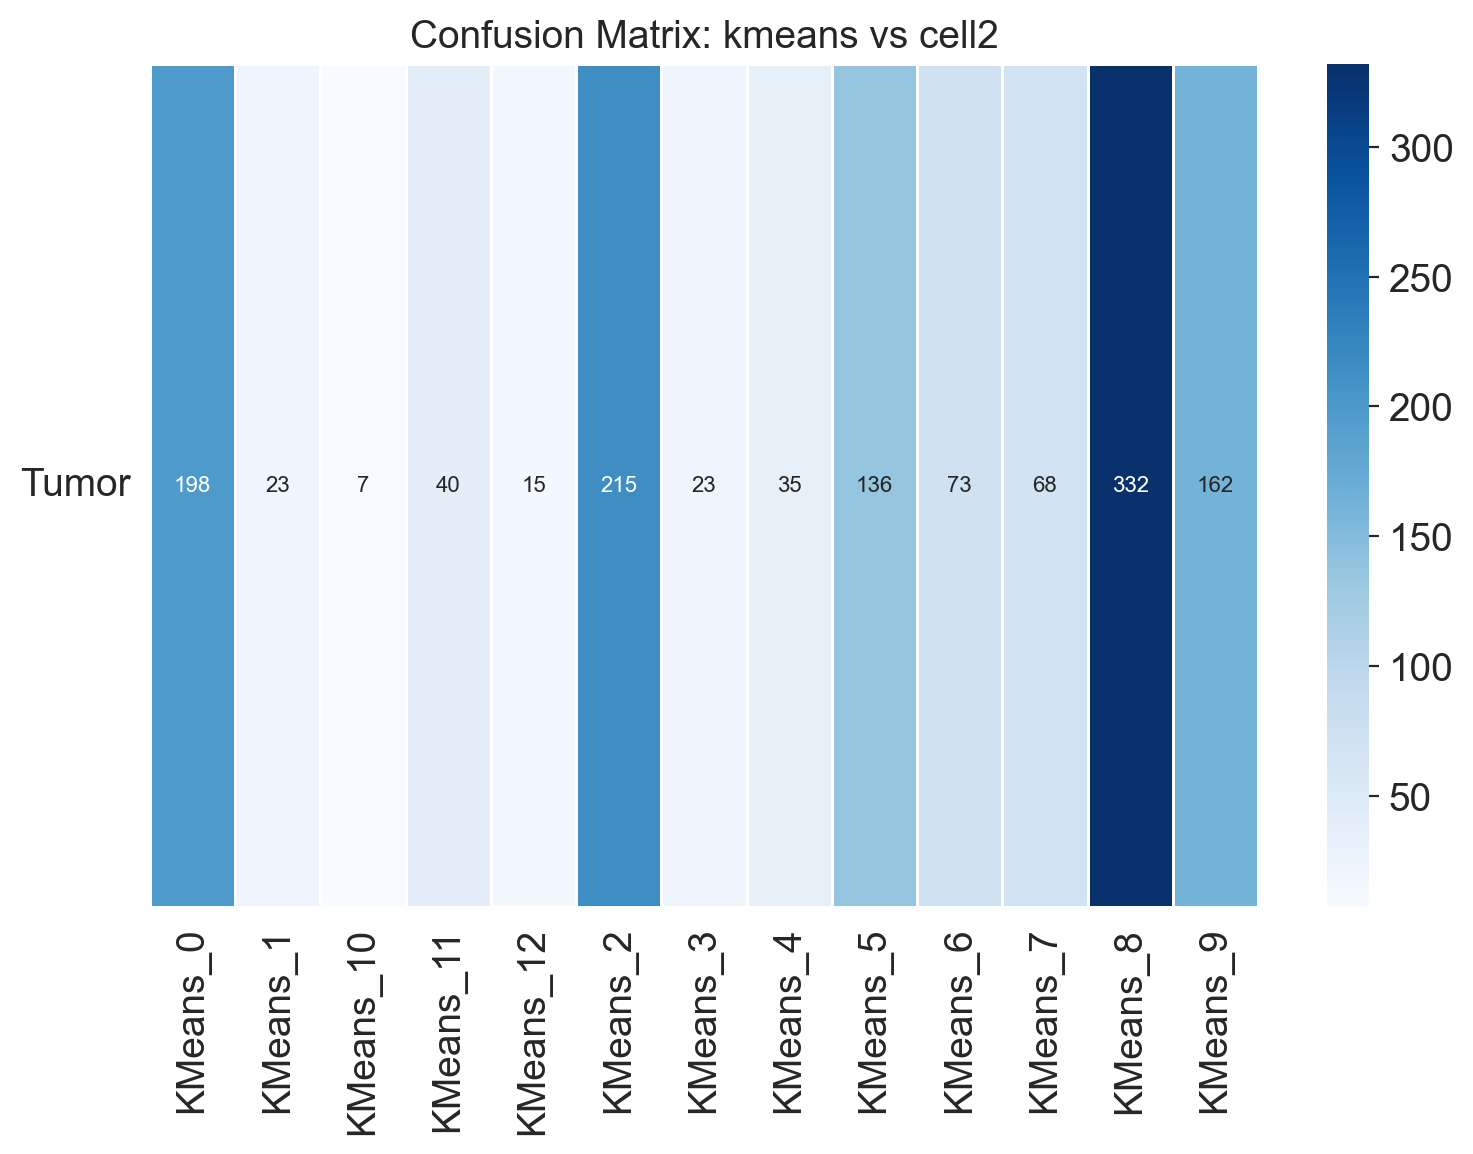

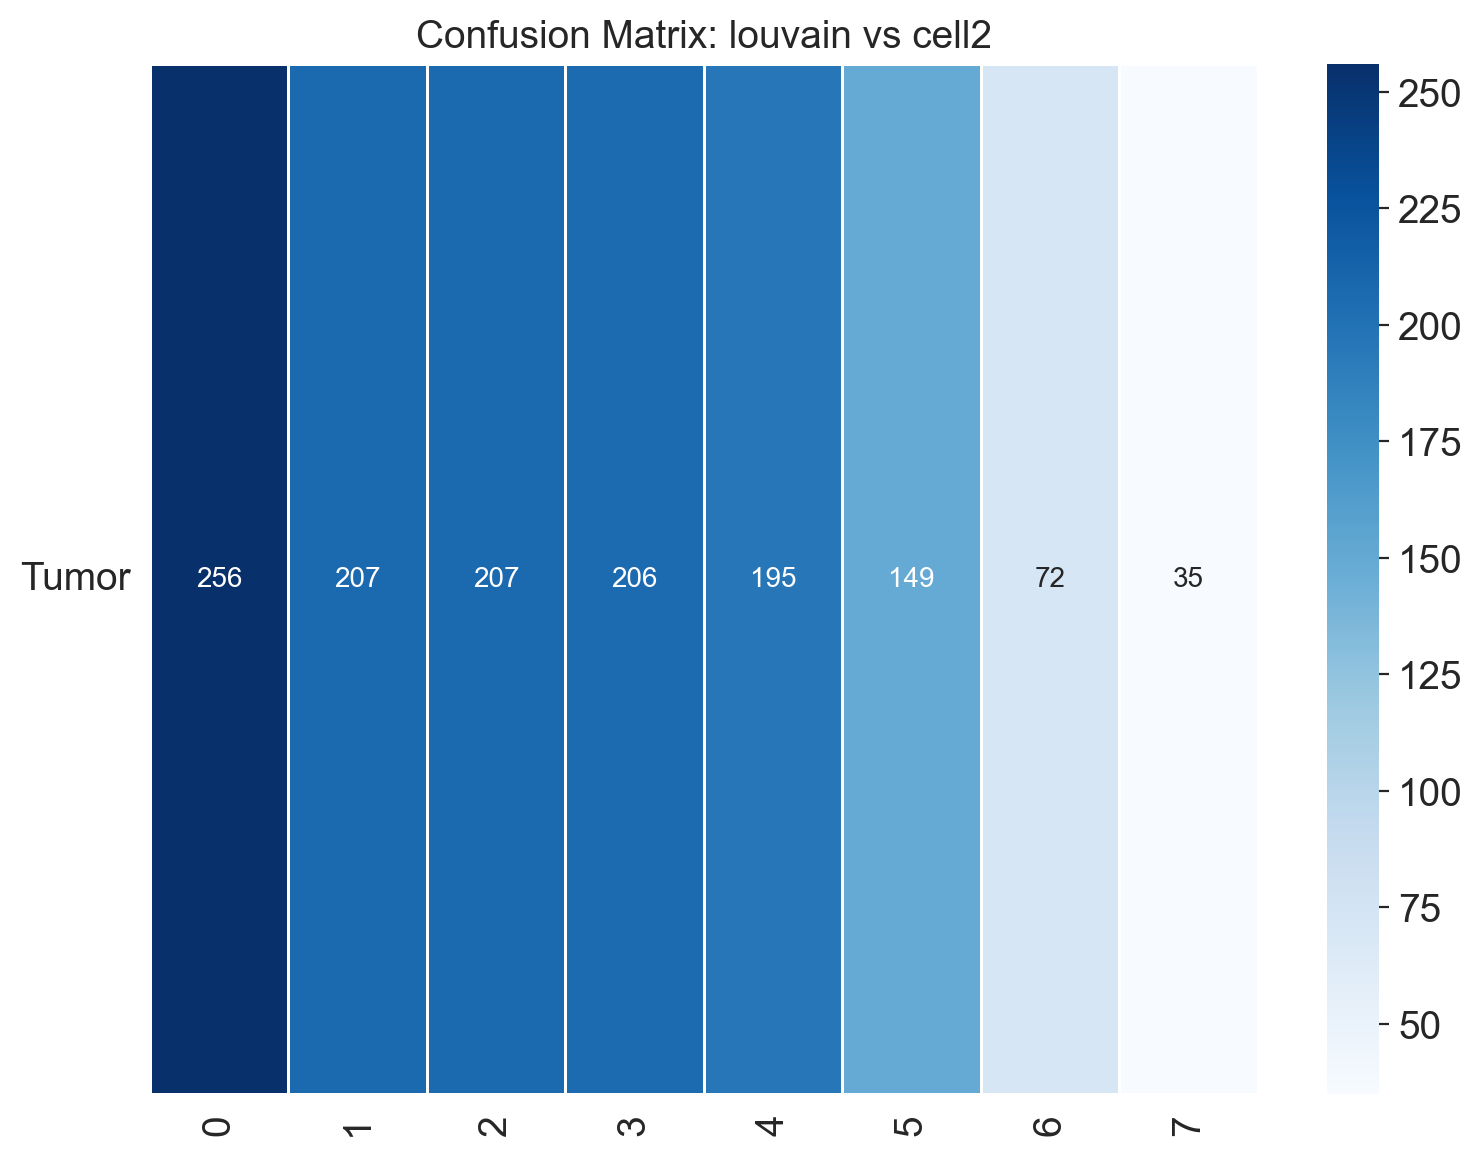

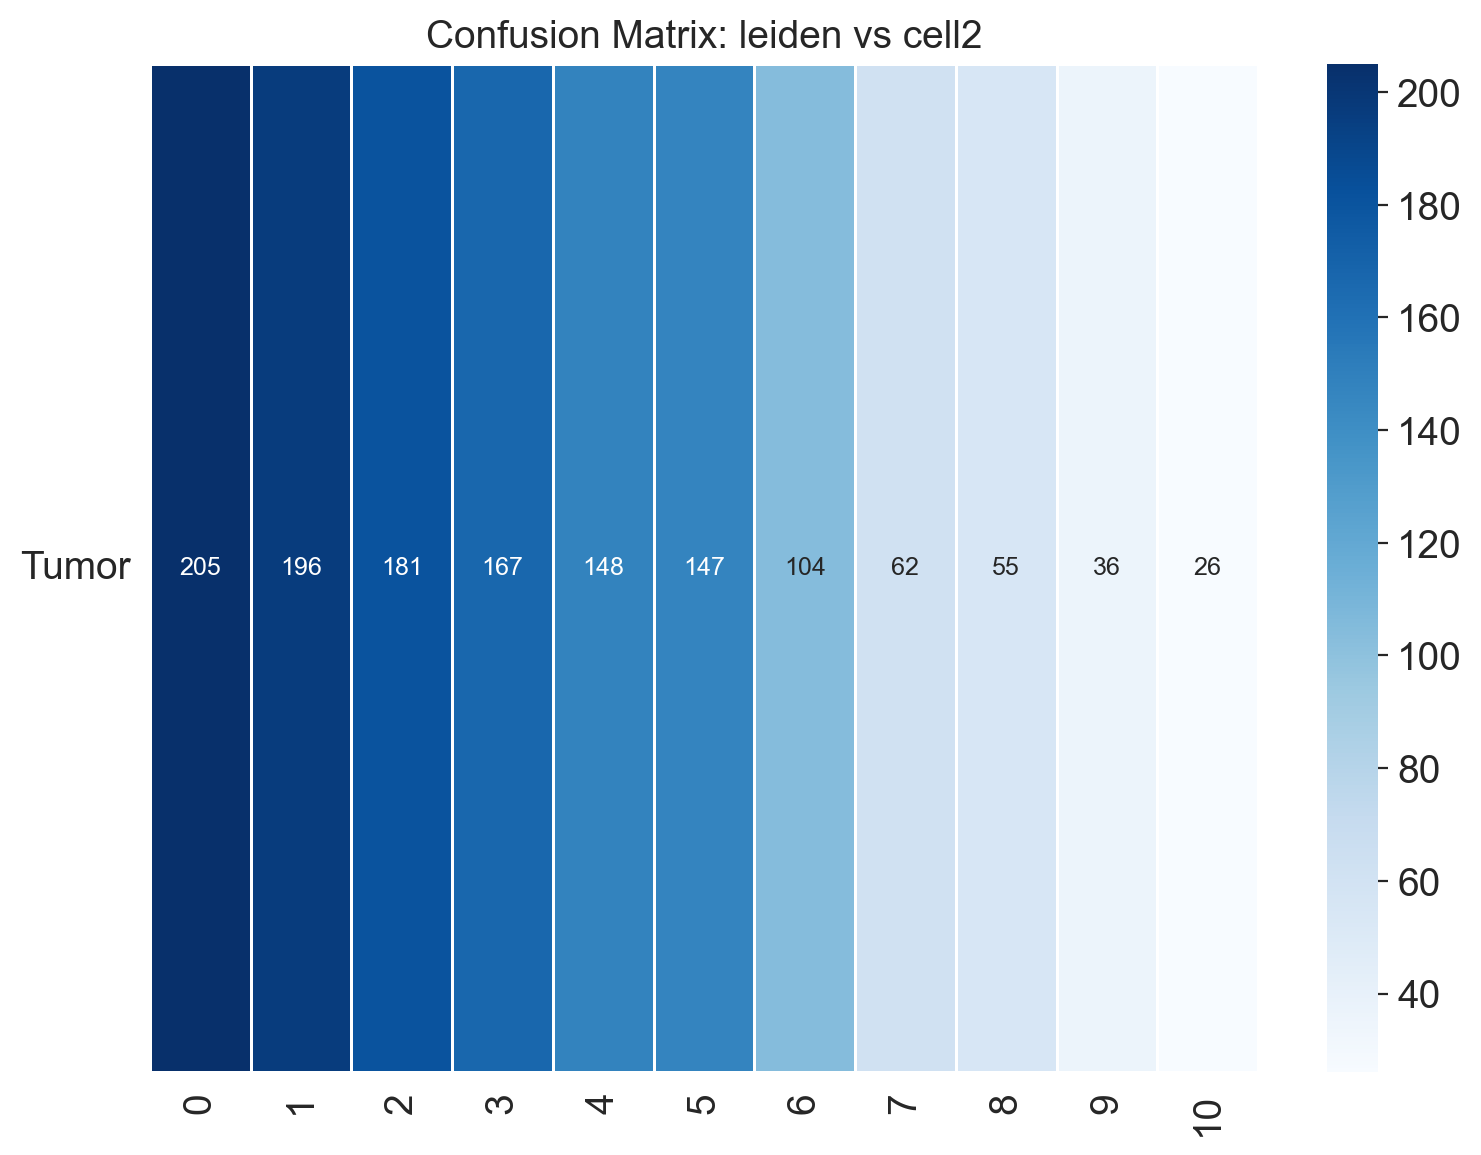


--- 3. Cluster Composition Bar Plots ---

Generating Composition Plot for: GMM_cluster


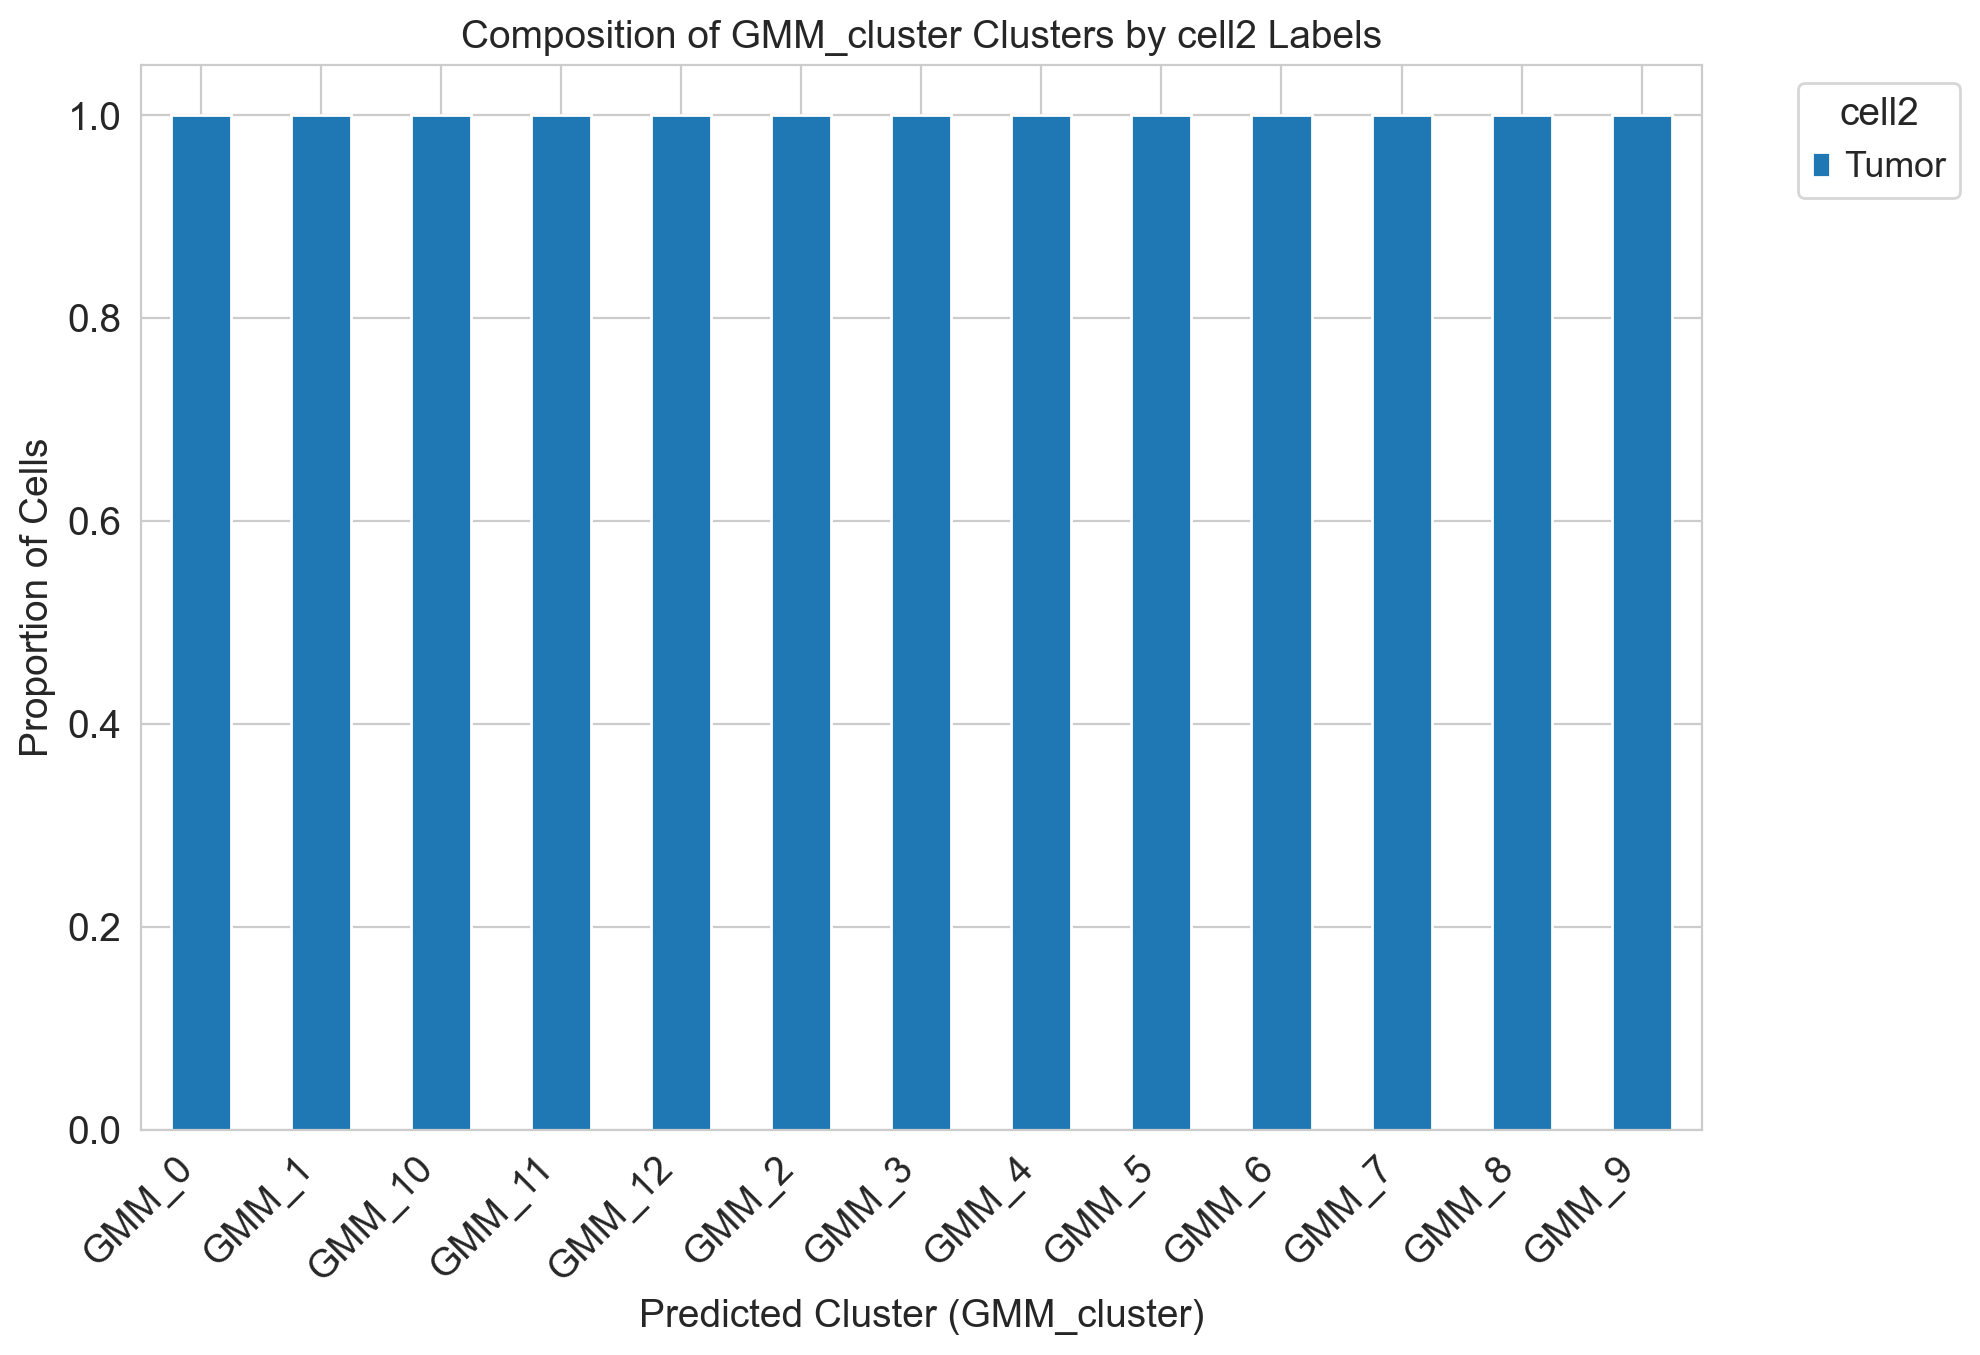


Generating Composition Plot for: kmeans


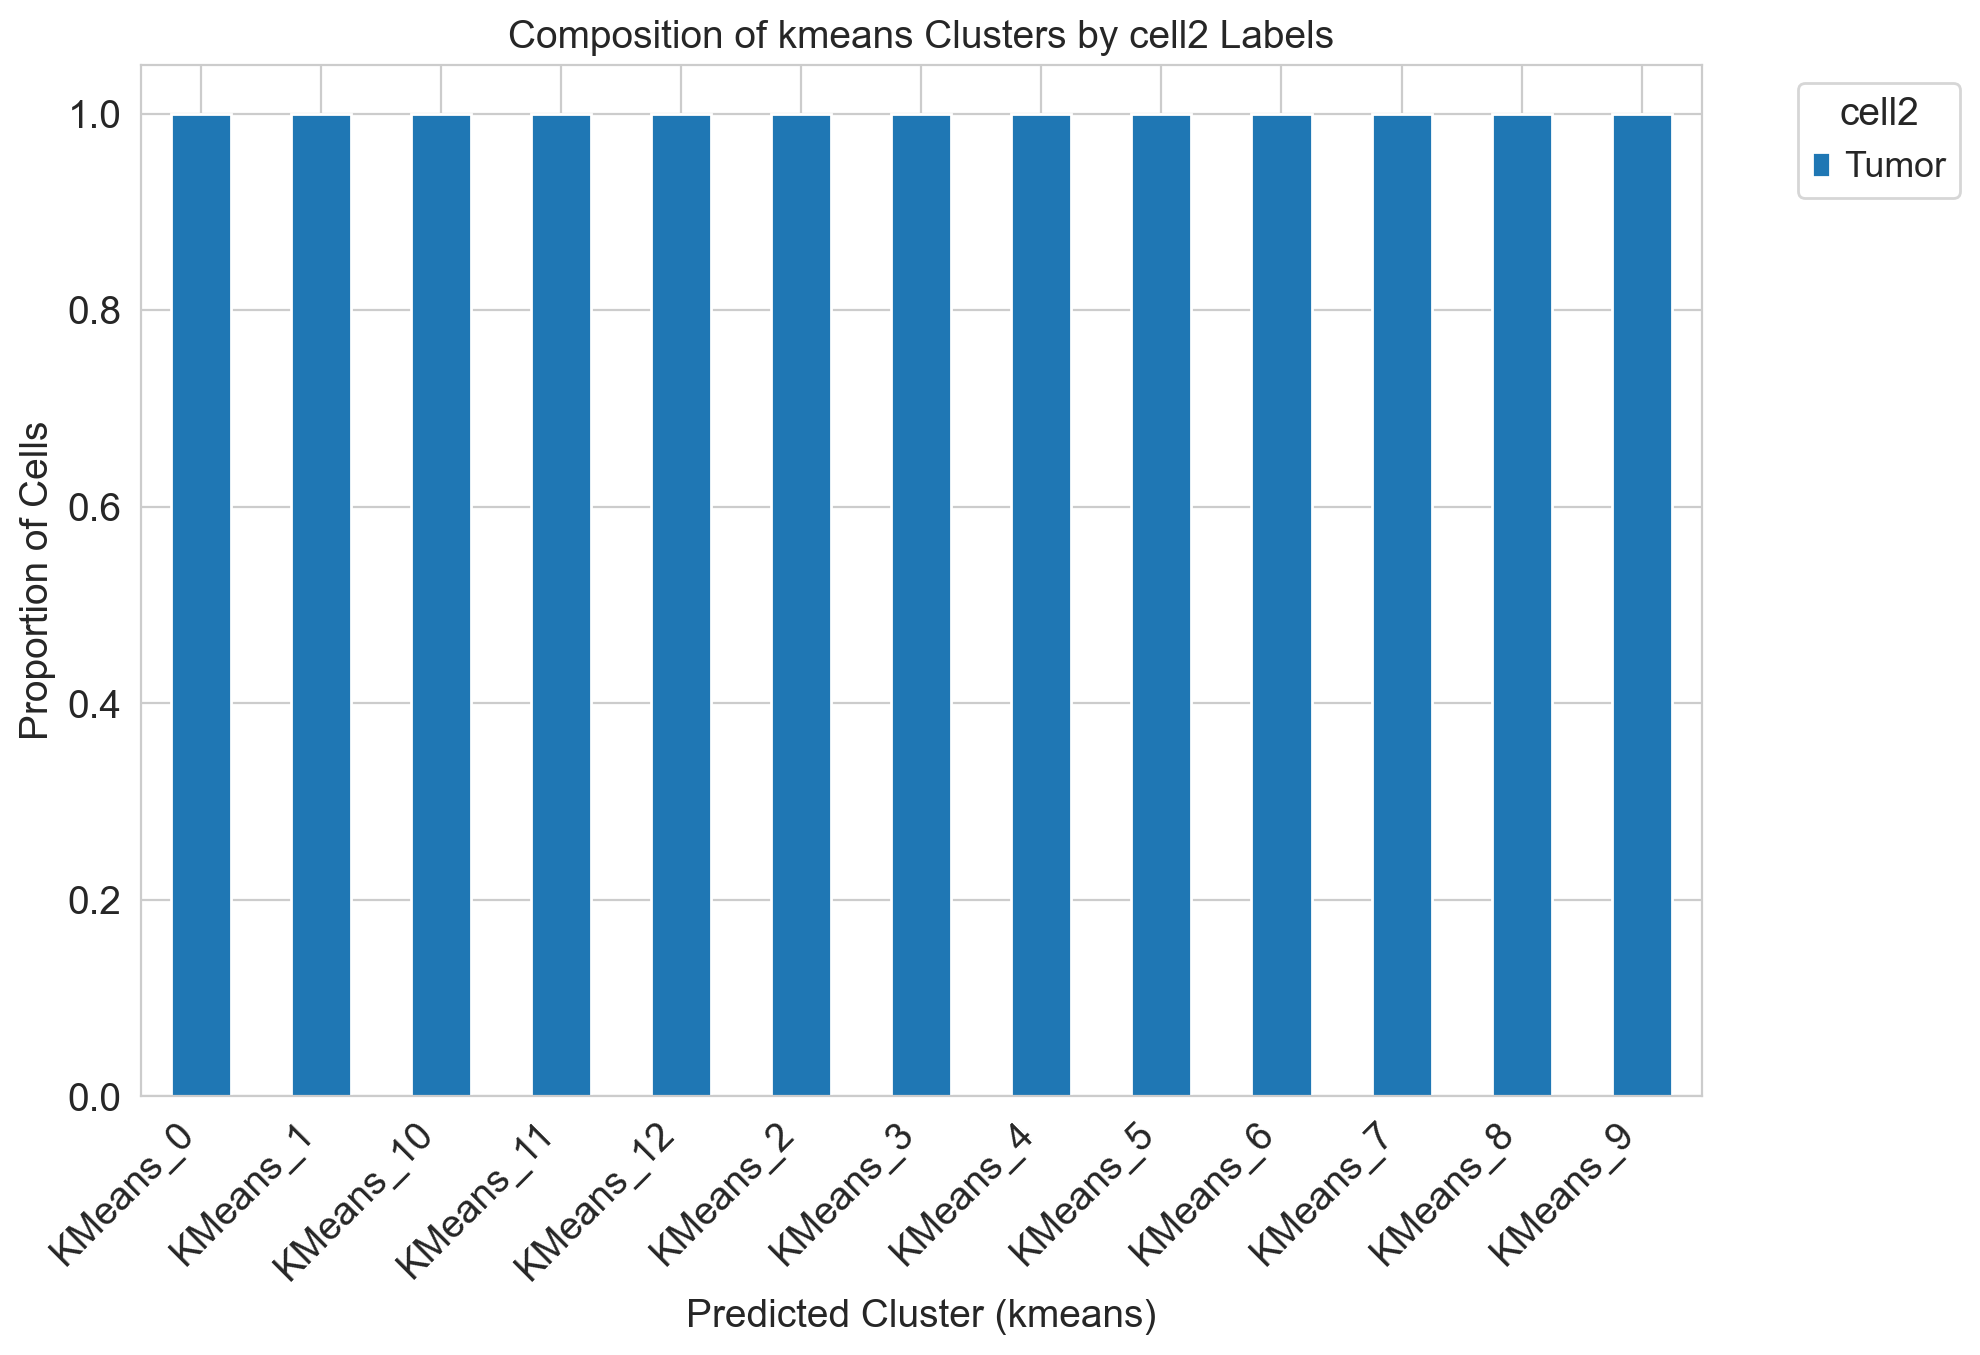


Generating Composition Plot for: louvain


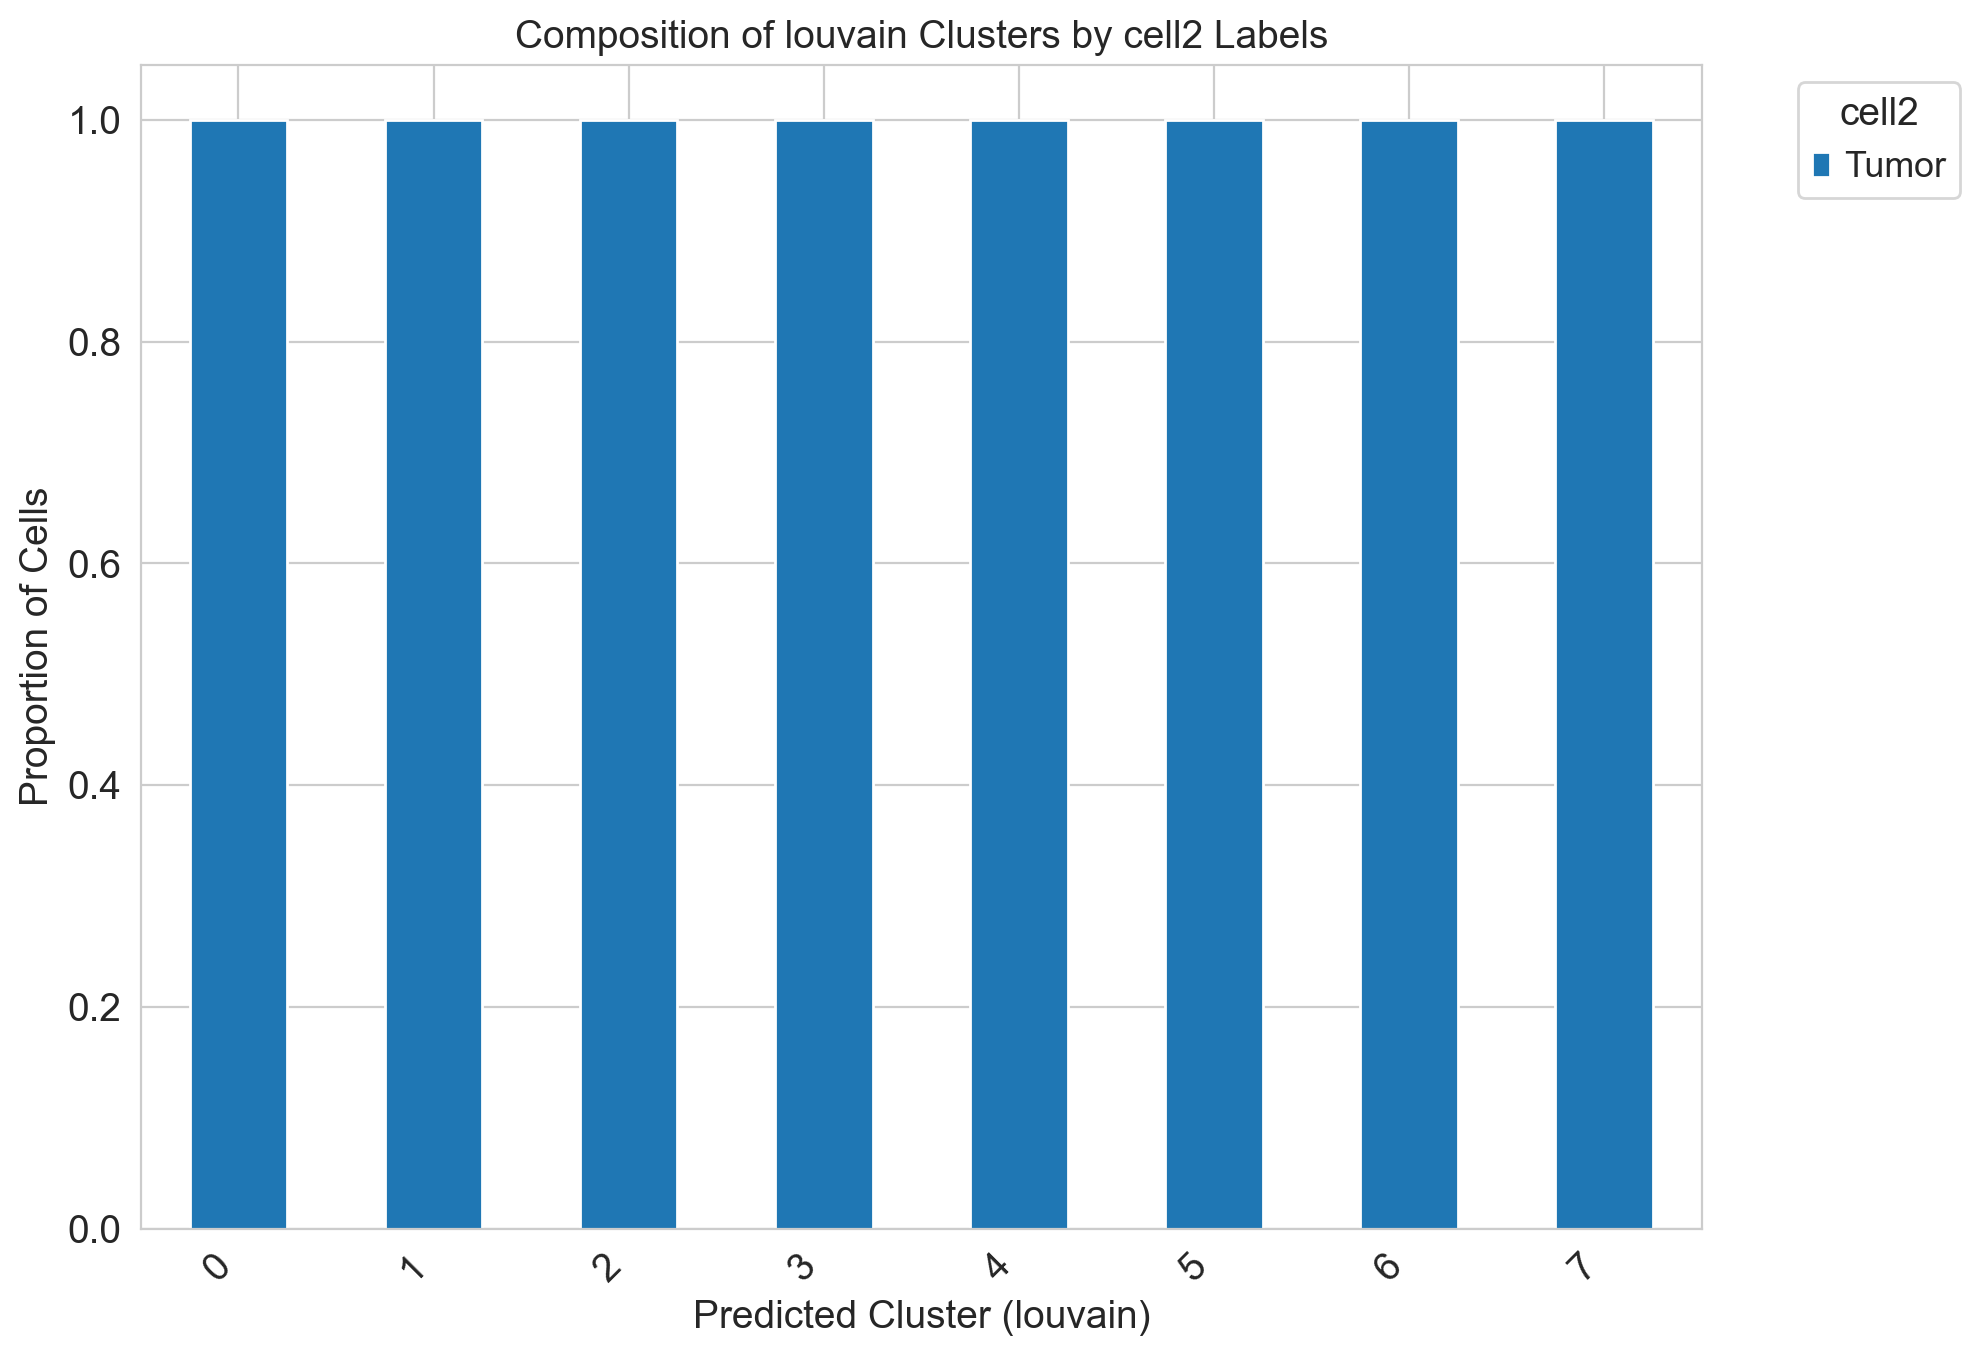


Generating Composition Plot for: leiden


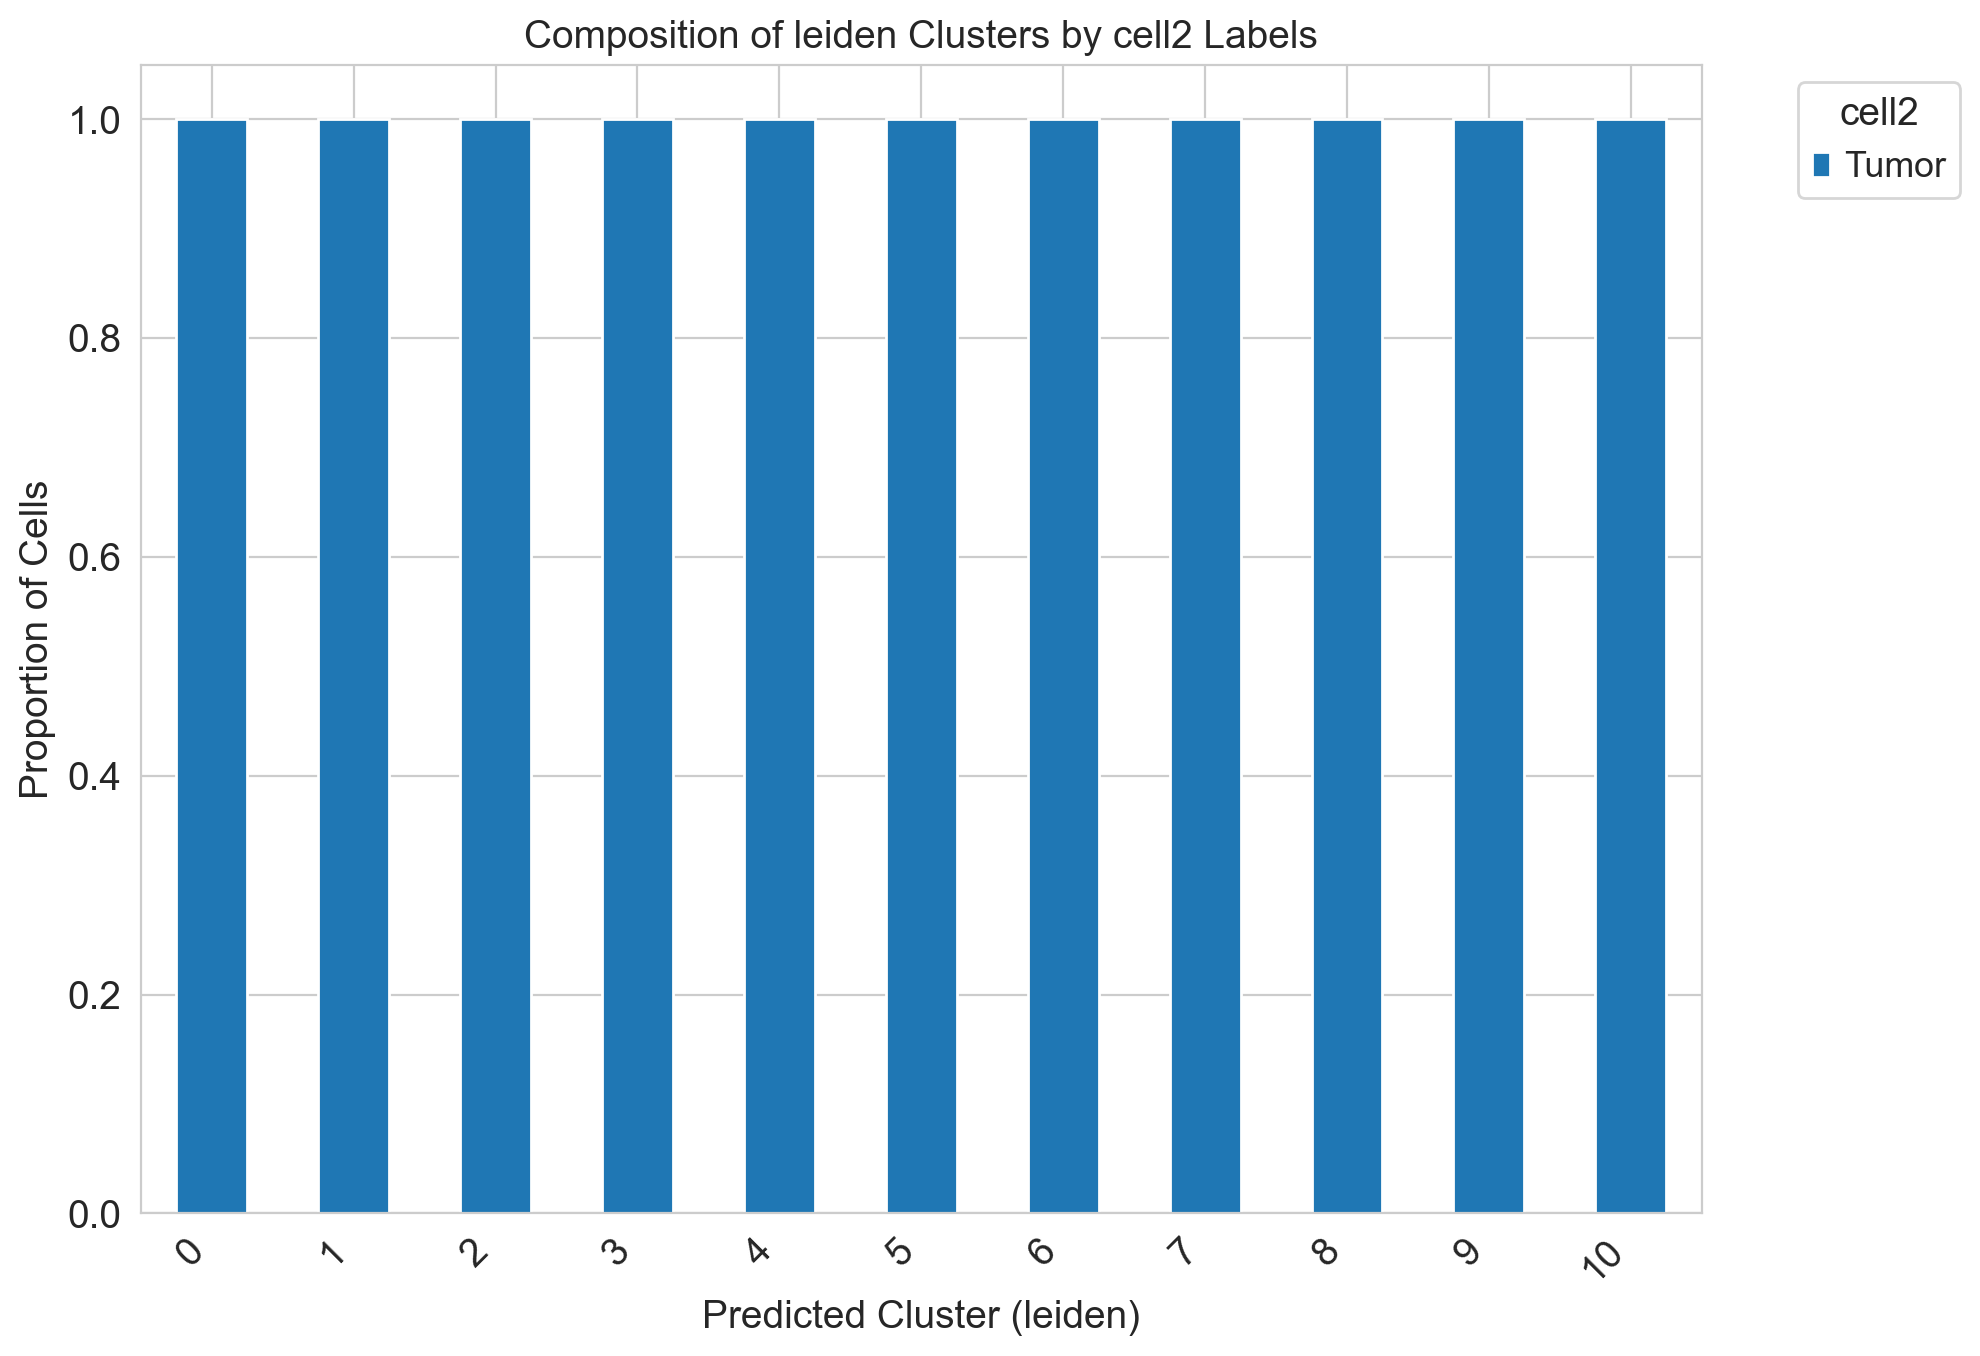


--- 4. GMM Entropy Distribution per 'cell2' Label ---


/var/folders/m2/lbk735w547j5jf8nwvk8vnj40000gn/T/ipykernel_30620/3923556724.py:157: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_entropy = entropy_df.groupby(ground_truth_key)['GMM_entropy'].median().sort_values()
/var/folders/m2/lbk735w547j5jf8nwvk8vnj40000gn/T/ipykernel_30620/3923556724.py:161: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=entropy_df, y=ground_truth_key, x='GMM_entropy', order=ordered_labels, palette='viridis')


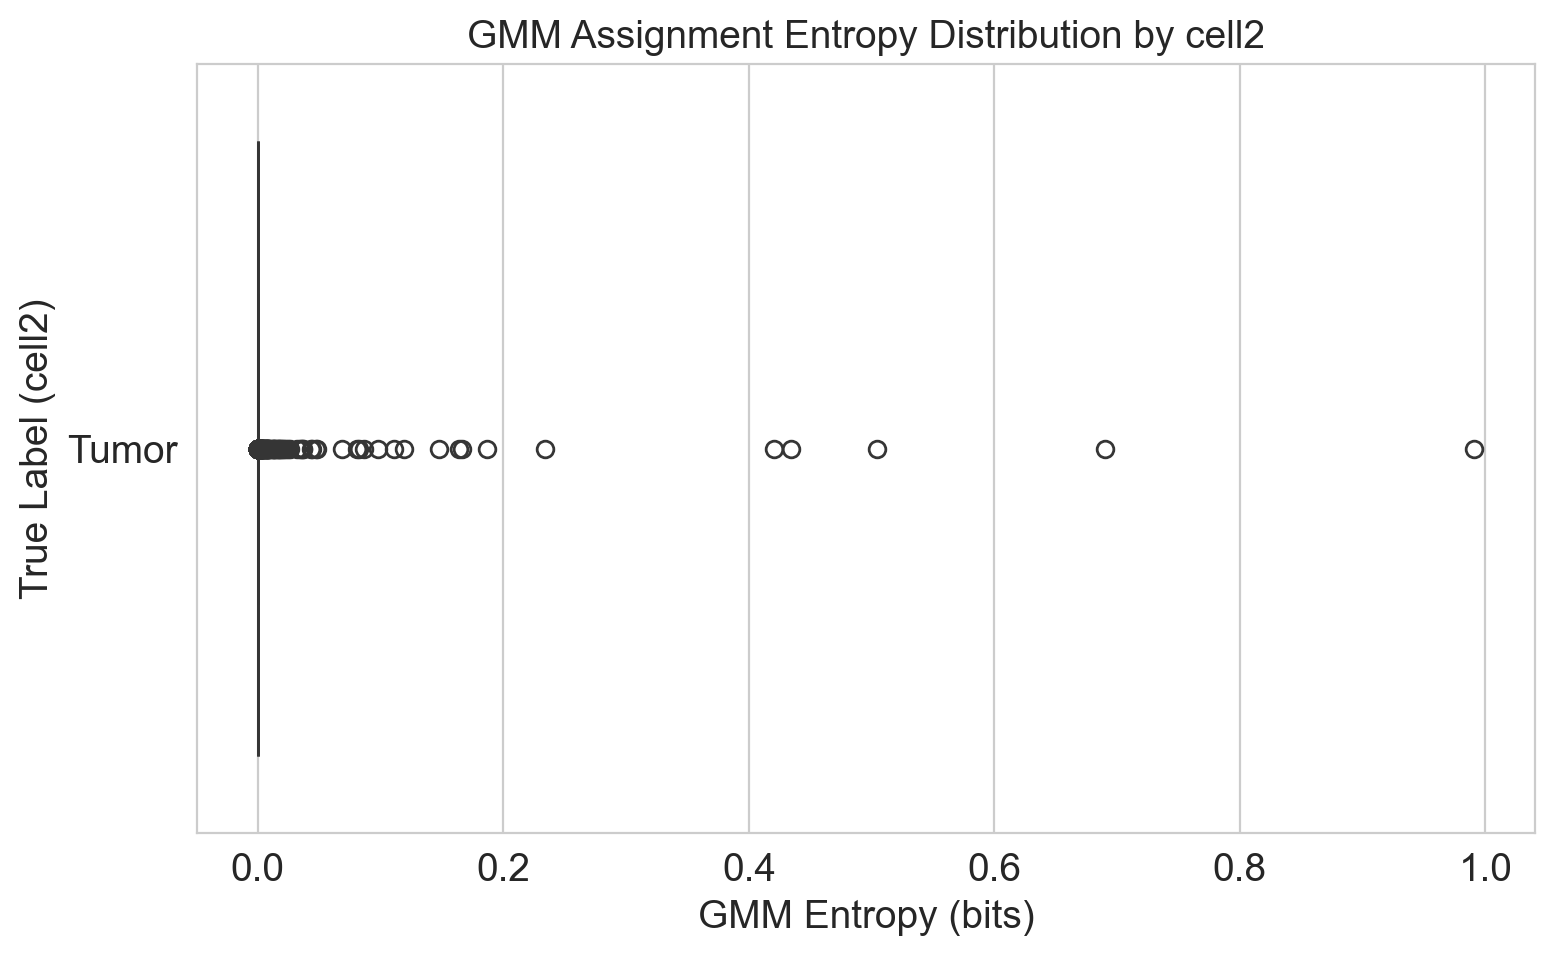


Interpretation Guide (?):
- Higher entropy for a cell indicates it has similar probabilities of belonging to multiple GMM clusters (more uncertainty/ambiguity).
- Lower entropy indicates the cell is strongly assigned to one GMM cluster.
- Examining entropy distribution within known 'cell2' groups can reveal:
  - Groups with consistently low entropy: Likely well-separated and confidently clustered by GMM.
  - Groups with consistently high entropy: May represent intermediate states, poorly separated populations, or areas where GMM struggles.
  - Groups with wide entropy variance: Might contain subpopulations with different clustering certainties.

--- Evaluation Complete ---



In [42]:
# --- Evaluation Against Known Cell-Identity Labels ---
print("\n" + "="*50)
print("--- Starting Evaluation Against Known Cell Labels ---")
print("="*50 + "\n")

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    adjusted_rand_score,
    normalized_mutual_info_score,
    homogeneity_score,
    completeness_score,
    v_measure_score,
    confusion_matrix
)


# Choose the clustering results columns from embed_adata.obs to evaluate
# The notebook previously added: 'GMM_cluster', 'kmeans', 'louvain', 'leiden'
clustering_keys = ['GMM_cluster', 'kmeans', 'louvain', 'leiden']

# --- Check if keys exist ---
if ground_truth_key not in embed_adata.obs.columns:
    raise KeyError(f"Ground truth key '{ground_truth_key}' not found in embed_adata.obs. Available keys: {list(embed_adata.obs.columns)}")

valid_clustering_keys = []
for key in clustering_keys:
    if key in embed_adata.obs.columns:
        valid_clustering_keys.append(key)
    else:
        print(f"Warning: Clustering key '{key}' not found in embed_adata.obs. Skipping evaluation for this key.")
clustering_keys = valid_clustering_keys

if not clustering_keys:
    print("No valid clustering keys found to evaluate. Exiting evaluation section.")
else:

    true_labels = embed_adata.obs[ground_truth_key]

    # --- 1. Calculate and Print Metrics ---
    print(f"\n--- 1. Clustering Evaluation Metrics (vs '{ground_truth_key}') ---")
    metrics_results = {}
    for key in clustering_keys:
        print(f"\nEvaluating: {key}")
        predicted_labels = embed_adata.obs[key]

        ari = adjusted_rand_score(true_labels, predicted_labels)
        nmi = normalized_mutual_info_score(true_labels, predicted_labels)
        homogeneity = homogeneity_score(true_labels, predicted_labels)
        completeness = completeness_score(true_labels, predicted_labels)
        v_measure = v_measure_score(true_labels, predicted_labels)

        metrics_results[key] = {
            'ARI': ari,
            'NMI': nmi,
            'Homogeneity': homogeneity,
            'Completeness': completeness,
            'V-Measure': v_measure
        }
        print(f"  Adjusted Rand Index (ARI): {ari:.4f}")
        print(f"  Normalized Mutual Info (NMI): {nmi:.4f}")
        print(f"  Homogeneity: {homogeneity:.4f}")
        print(f"  Completeness: {completeness:.4f}")
        print(f"  V-Measure: {v_measure:.4f}")

    # Display metrics as a DataFrame
    metrics_df = pd.DataFrame(metrics_results).T
    print("\n--- Metrics Summary ---")
    print(metrics_df)
    print("-" * 25)


    # --- 2. Generate Confusion Matrices ---
    print(f"\n--- 2. Confusion Matrices (True Labels vs Predicted Clusters) ---")
    # Ensure true labels are categorical for proper ordering if they aren't already
    if not isinstance(true_labels, pd.CategoricalDtype):
        true_labels = true_labels.astype('category')
    true_label_names = true_labels.cat.categories

    for key in clustering_keys:
        print(f"\nGenerating Confusion Matrix for: {key}")
        predicted_labels = embed_adata.obs[key]

        if not isinstance(predicted_labels.dtype, pd.CategoricalDtype):
            predicted_labels = predicted_labels.astype('category')
        predicted_label_names = predicted_labels.cat.categories

        # Create confusion matrix dataframe using crosstab for correct labeling
        cm_df = pd.crosstab(true_labels, predicted_labels, rownames=[f'True ({ground_truth_key})'], colnames=[f'Predicted ({key})'])
        # Reindex to ensure all true labels are present and in consistent order, recheck this
        cm_df = cm_df.reindex(index=true_label_names, columns=predicted_label_names, fill_value=0)

        # Determine figure size dynamically
        fig_width = max(8, len(predicted_label_names) * 0.6)
        fig_height = max(6, len(true_label_names) * 0.4)
        annotation_size = max(6, 14 - max(len(predicted_label_names), len(true_label_names)) // 2) # Dynamically adjust annotation size

        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(
            cm_df,
            annot=True,
            fmt="d", # Format as integer
            cmap="Blues",
            linewidths=.5,
            annot_kws={"size": annotation_size} # Adjust annotation font size here
        )
        plt.title(f'Confusion Matrix: {key} vs {ground_truth_key}')
        # Labels are now set by crosstab rownames/colnames
        # plt.ylabel(f'True Labels ({ground_truth_key})') # No longer needed
        # plt.xlabel(f'Predicted Clusters ({key})') # No longer needed
        plt.xticks(rotation=90)
        plt.yticks(rotation=0)
        plt.tight_layout()
    plt.show()


    # --- 3. Generate Stacked Bar Plots for Cluster Composition ---
    print(f"\n--- 3. Cluster Composition Bar Plots ---")
    # Using a qualitative colormap suitable for many categories
    try:
        # Try tab20 which has 20 distinct colors, fallback if fewer categories
        colors = plt.get_cmap('tab20').colors
    except ValueError:
        colors = plt.get_cmap('viridis').colors # Fallback

    for key in clustering_keys:
        print(f"\nGenerating Composition Plot for: {key}")
        # Create a cross-tabulation: counts of each true label within each predicted cluster
        ct = pd.crosstab(embed_adata.obs[key], embed_adata.obs[ground_truth_key])

        # Normalize by cluster (column sum = 1) to show percentage composition
        ct_norm = ct.apply(lambda x: x / x.sum(), axis=1)

        # Plotting
        ax = ct_norm.plot(kind='bar', stacked=True, figsize=(12, 7),
                          color=colors[:len(true_label_names)]) # Use subset of colors
        plt.title(f'Composition of {key} Clusters by {ground_truth_key} Labels')
        plt.xlabel(f'Predicted Cluster ({key})')
        plt.ylabel('Proportion of Cells')
        plt.xticks(rotation=45, ha='right')
        # Place legend outside the plot
        plt.legend(title=ground_truth_key, bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust rect to make space for legend
        # plt.savefig(f'composition_plot_{key}.png', dpi=150, bbox_inches='tight')
        plt.show()


    # --- 4. Examine GMM Entropy Distribution per Known Label ---
    if 'GMM_entropy' in embed_adata.obs.columns and 'GMM_cluster' in clustering_keys:
        print(f"\n--- 4. GMM Entropy Distribution per '{ground_truth_key}' Label ---")

        # Create a DataFrame for easier plotting with seaborn
        entropy_df = embed_adata.obs[[ground_truth_key, 'GMM_entropy']].copy()

        # Calculate median entropy for sorting categories
        median_entropy = entropy_df.groupby(ground_truth_key)['GMM_entropy'].median().sort_values()
        ordered_labels = median_entropy.index

        plt.figure(figsize=(8, max(5, len(ordered_labels) * 0.3))) # Adjust height based on number of labels
        sns.boxplot(data=entropy_df, y=ground_truth_key, x='GMM_entropy', order=ordered_labels, palette='viridis')
        plt.title(f'GMM Assignment Entropy Distribution by {ground_truth_key}')
        plt.xlabel('GMM Entropy (bits)')
        plt.ylabel(f'True Label ({ground_truth_key})')
        plt.tight_layout()
        # plt.savefig(f'gmm_entropy_by_{ground_truth_key}.png', dpi=150, bbox_inches='tight') 
        plt.show()

        print("\nInterpretation Guide (?):")
        print(f"- Higher entropy for a cell indicates it has similar probabilities of belonging to multiple GMM clusters (more uncertainty/ambiguity).")
        print(f"- Lower entropy indicates the cell is strongly assigned to one GMM cluster.")
        print(f"- Examining entropy distribution within known '{ground_truth_key}' groups can reveal:")
        print(f"  - Groups with consistently low entropy: Likely well-separated and confidently clustered by GMM.")
        print(f"  - Groups with consistently high entropy: May represent intermediate states, poorly separated populations, or areas where GMM struggles.")
        print(f"  - Groups with wide entropy variance: Might contain subpopulations with different clustering certainties.")
    elif 'GMM_entropy' not in embed_adata.obs.columns:
         print(f"\n--- Skipping GMM Entropy analysis: 'GMM_entropy' not found in embed_adata.obs ---")
    else: # GMM_entropy exists but GMM_cluster wasn't evaluated
         print(f"\n--- Skipping GMM Entropy analysis: 'GMM_cluster' was not included in evaluated clustering_keys ---")


print("\n" + "="*50)
print("--- Evaluation Complete ---")
print("="*50 + "\n")

Zero-shot Integration copied and applied to the following embedding data.

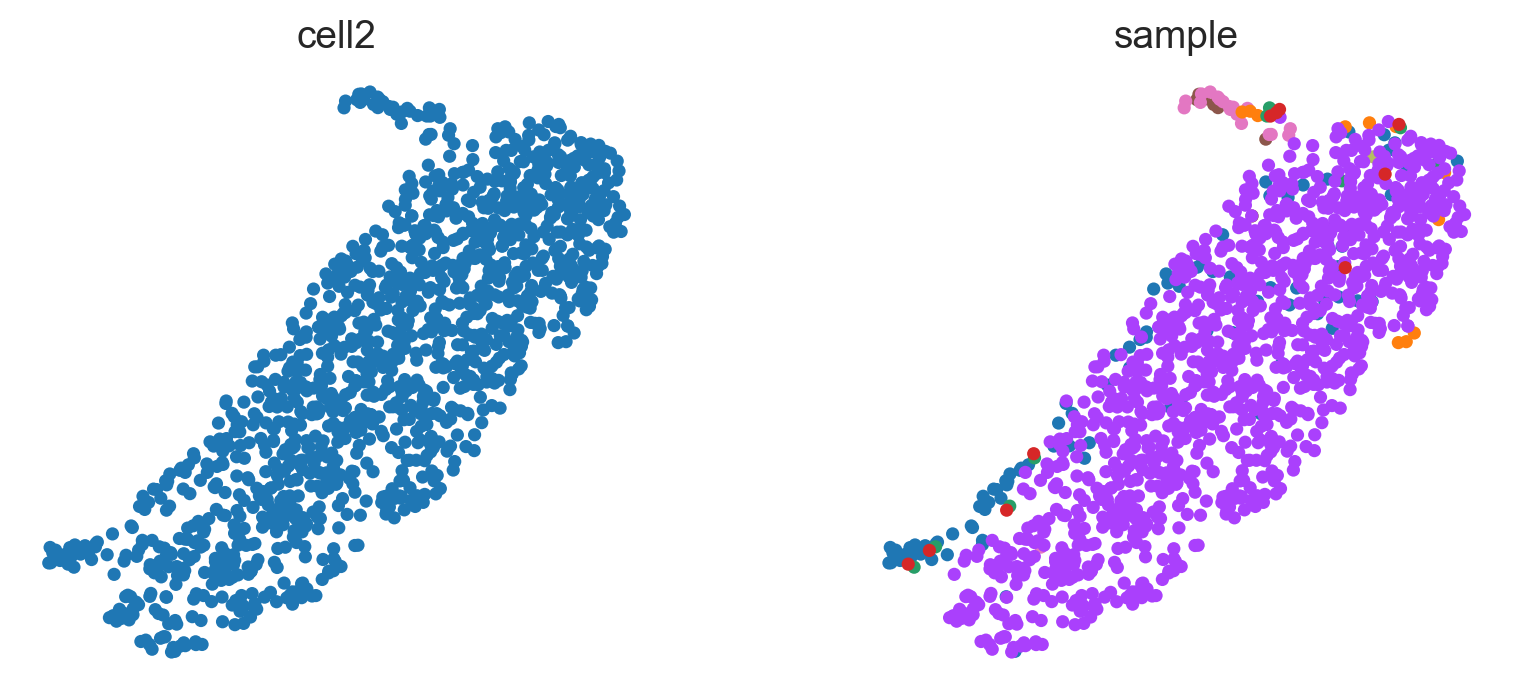

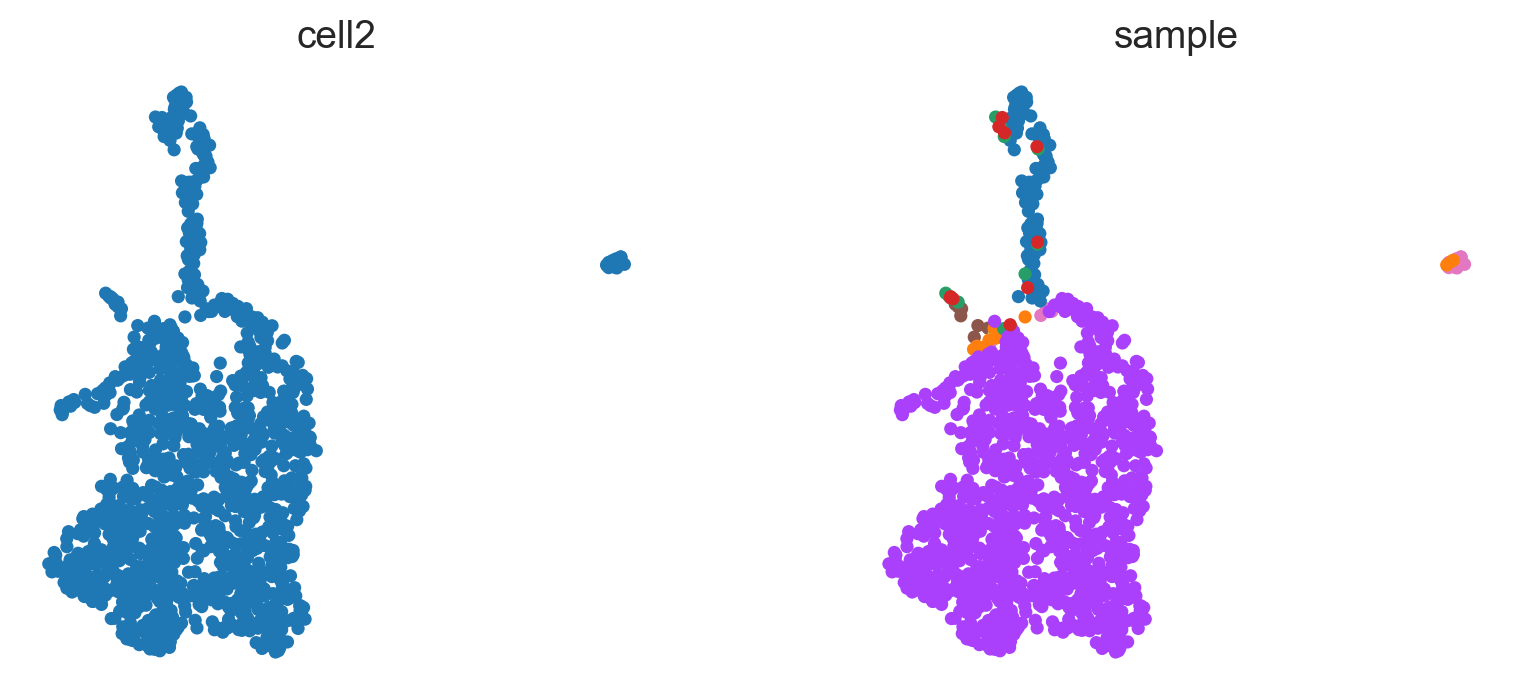

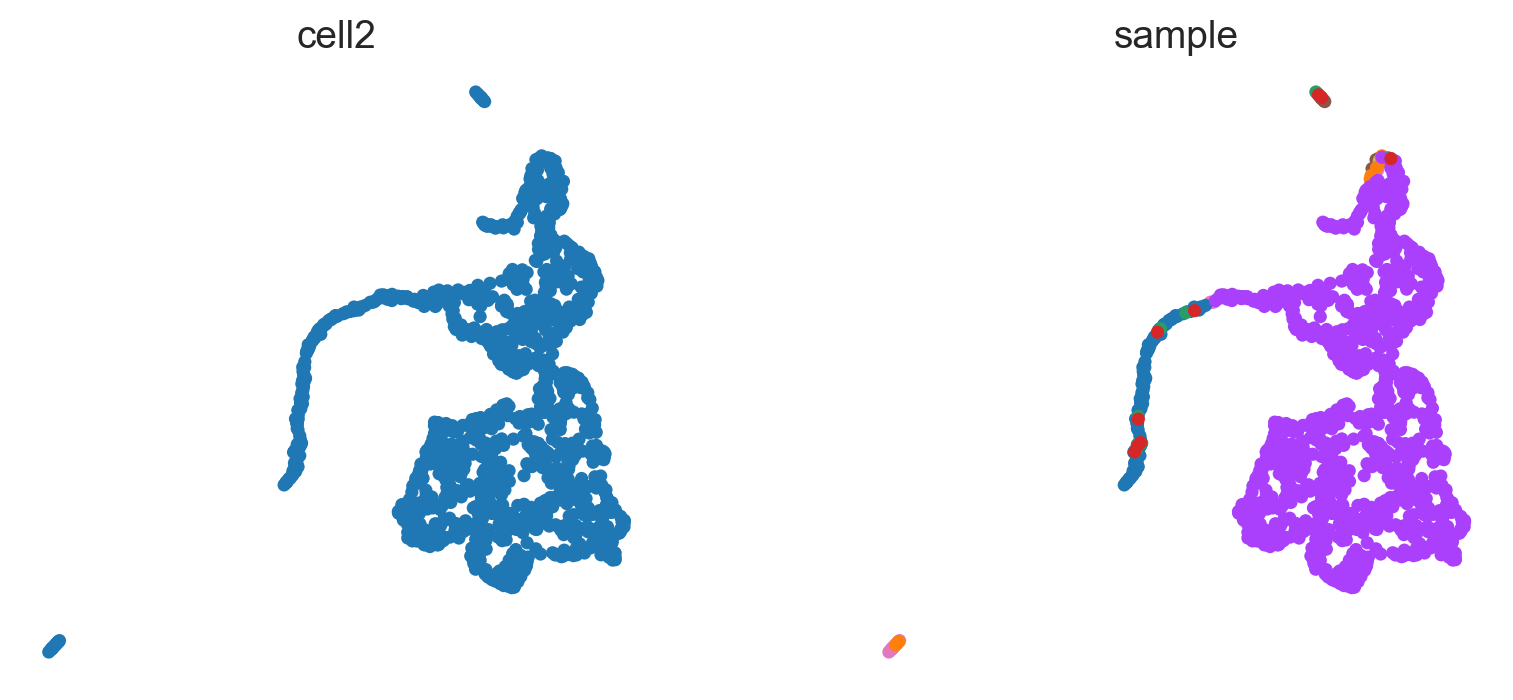

In [43]:
from scib_metrics.benchmark import Benchmarker, BioConservation, BatchCorrection
os.makedirs("./bench_figures", exist_ok=True)
for rep in ['CancerGPT', 'X_pca', 'X_umap']:
    sc.pp.neighbors(embed_adata, use_rep=rep)
    sc.tl.umap(embed_adata)
    fig = sc.pl.umap(embed_adata, 
            color=["cell2", "sample"], 
            frameon=False, 
            palette=sc.pl.palettes.default_20,
            legend_loc=None,
            return_fig=True)
    fig.savefig(f"figures/{rep}_umap.png", dpi=300, bbox_inches="tight")

In [44]:
bio_conservation = BioConservation(nmi_ari_cluster_labels_kmeans=False, nmi_ari_cluster_labels_leiden=True)
batch_correction = BatchCorrection(pcr_comparison=False)

bm = Benchmarker(
    embed_adata,
    batch_key="sample",
    label_key="cell2",
    embedding_obsm_keys=['CancerGPT', 'X_pca', 'X_umap'],
    n_jobs=6,
    bio_conservation_metrics = bio_conservation,
    batch_correction_metrics=batch_correction,
)

bm.benchmark()

/Users/matinurdu/Desktop/ETH_Zürich/FS25/Foundation_models_NB/.venv/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:377: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)
Embeddings:   0%|          | 0/3 [00:00<?, ?it/s]/Users/matinurdu/Desktop/ETH_Zürich/FS25/Foundation_models_NB/.venv/lib/python3.9/site-packages/scib_metrics/_lisi.py:102: RuntimeWarning: invalid value encountered in scalar divide
  clisi = (nlabels - clisi) / (nlabels - 1)
/Users/matinurdu/Desktop/ETH_Zürich/FS25/Foundation_models_NB/.venv/lib/python3.9/site-packages/scib_metrics/_graph_connectivity.py:30: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(comps)
Embeddings:  33%|███▎      | 1/3 

/Users/matinurdu/Desktop/ETH_Zürich/FS25/Foundation_models_NB/.venv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


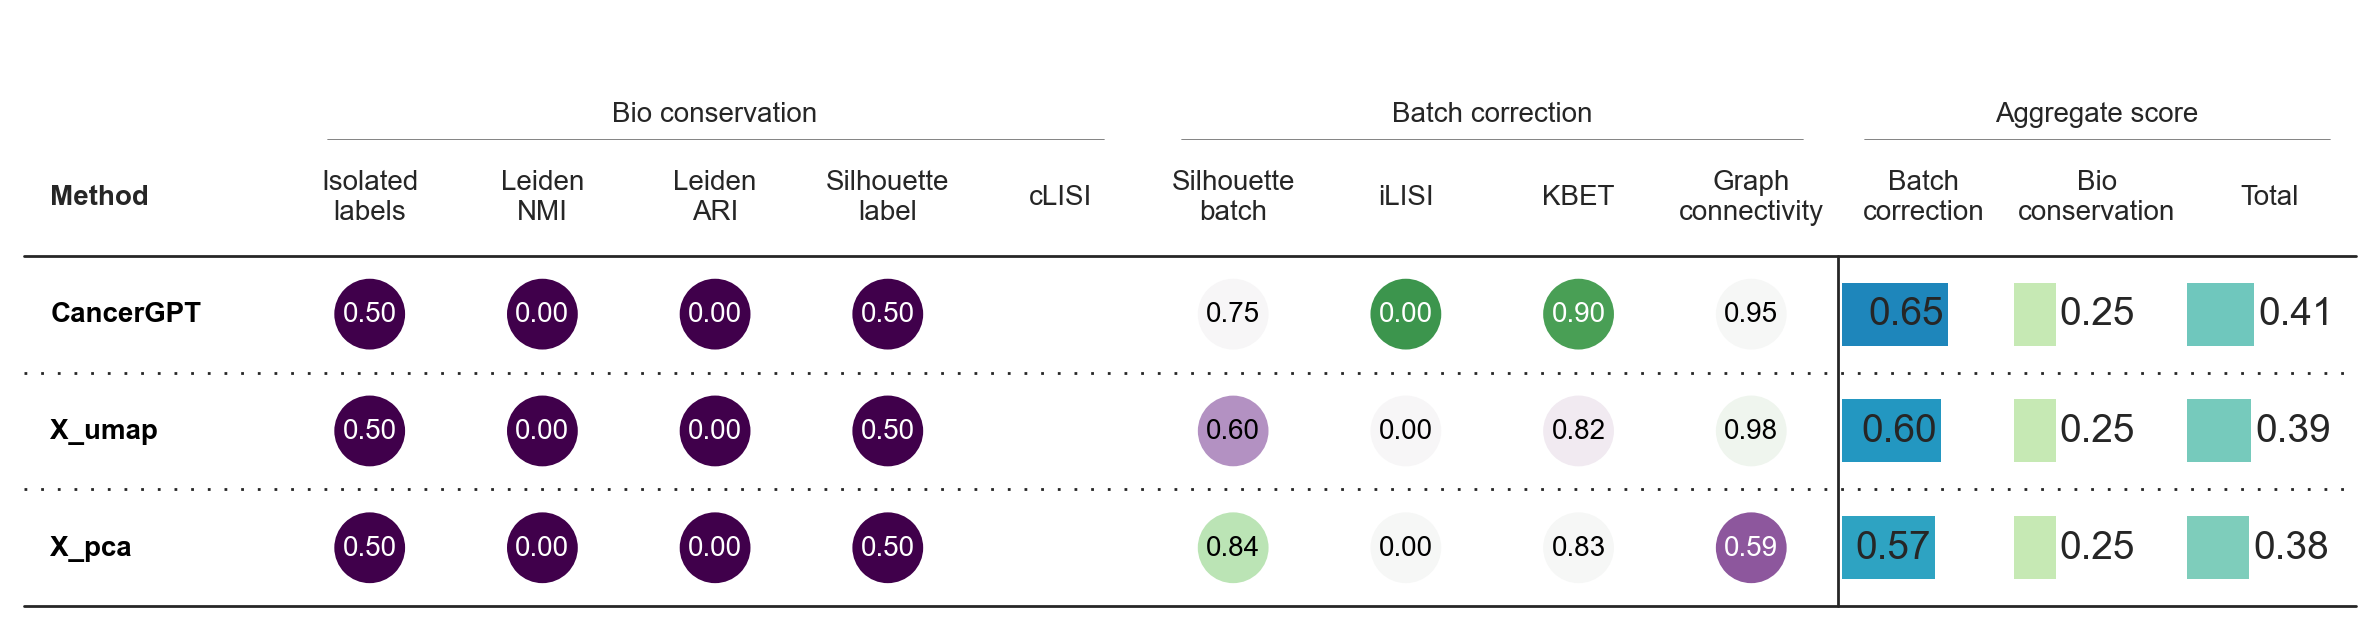

In [45]:
bm.plot_results_table(min_max_scale=False, save_dir="./figures")